In [24]:
import os
import sys 
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import plotly
import plotly.graph_objects as go
import plotly.express as px
import kaleido ##pip install -U kaleido ##to save a plotly fig
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score,cross_val_predict

In [63]:
df1 = pd.read_csv('Stable_Data_CSV.csv')
df2 = pd.read_csv('all_features.csv')
df_stable = df2[df2.set_index(['participant_id']).index.isin(df1.set_index(['participant_id']).index)]

# dataset with all features [34 features * 3 timesteps + 1 response variable]
df_stable=df_stable.drop(['participant_id','arm'],axis=1)

#dataset with selected fetures [[8 features * 3 timesteps + 1 response variable]]
df_stable_FS=(df_stable[['c_3','sl_1','sl_2','a_2','r_1','q_1','e_1','tfi_total','c_3.1','sl_1.1','sl_2.1','a_2.1','r_1.1','q_1.1','e_1.1','tfi_total.1','c_3.2','sl_1.2','sl_2.2','a_2.2','r_1.2','q_1.2','e_1.2','tfi_total.2','tfi_total.3']])

###  Dataset with all features

In [71]:
n_epochs=500
n_batch_size=32 
n_timesteps=3
n_features=34
lr=0.0001
kfold = KFold(n_splits=5)
error_scores=[]

def data_prep(df):
    sc_x=StandardScaler()
    sc_y=StandardScaler()
    ## Separate dependent and independent features 
    X=df.drop(['tfi_total.3'],axis=1).values
    y = df[['tfi_total.3']].values
    #scale x
    x_scaler=sc_x.fit(X)
    X=x_scaler.transform(X)
    #scale y
    y_scaler=sc_y.fit(y)
    y=y_scaler.transform(y)
    # Reshape input to be 3D for LSTM[samples, timesteps, features]
    X = X.reshape((X.shape[0],n_timesteps,n_features))
    print(X.shape,y.shape)
    input_shape=(n_timesteps,X.shape[2])
    print(input_shape)
    return X,y,input_shape,x_scaler,y_scaler

def create_lstm_model(input_shape,y_scaler):
    
    def error_in_tfi(y_true,y_pred): 
        y=y_true.numpy()
        yhat=y_pred.numpy()
        y=np.reshape(y, (1,-1))
        yhat=np.reshape(yhat, (1,-1))
        y=y_scaler.inverse_transform(y)
        yhat=y_scaler.inverse_transform(yhat)
        y=tf.convert_to_tensor(y, dtype=tf.float32)
        yhat=tf.convert_to_tensor(yhat, dtype=tf.float32)
        return K.mean(abs(y - yhat), axis=-1)  #K.mean(square(y_true - y_pred), axis=-1)
    
    K.clear_session
    input_shape=input_shape
    model = Sequential([
      LSTM(50, activation='relu',return_sequences=True,input_shape=input_shape),
      Dropout(0.2),
      LSTM(30, activation='relu',return_sequences=True,input_shape=input_shape),
      Dropout(0.2),
      LSTM(20, activation='relu',input_shape=input_shape),
      Dropout(0.2), 
      Dense(1,kernel_initializer='normal',activation = 'linear')                      
    ])             

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr),run_eagerly=True,metrics=[error_in_tfi])
    return model
    
def cross_val(df,error_scores):
    X,y,input_shape,x_scaler,y_scaler=data_prep(df)
    for train_index, test_index in kfold.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model=create_lstm_model(input_shape,y_scaler)
        history=model.fit(x_train, y_train,epochs=n_epochs,batch_size=n_batch_size,validation_split=0.2,verbose =1)#validation_data=(x_test,y_test) #validation_split=0.2
        val_mse,val_mae=model.evaluate(x_test,y_test)  
        error_scores.append(val_mae)
    return history,x_scaler,y_scaler,error_scores

history,x_scaler,y_scaler,error_scores_mae=cross_val(df_stable,error_scores)   

(61, 3, 34) (61, 1)
(3, 34)
TRAIN: [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Epoch 1/500
2/2 [==============================] - 0s 202ms/step - loss: 0.9525 - error_in_tfi: 21.5521 - val_loss: 0.9417 - val_error_in_tfi: 18.2570
Epoch 2/500
2/2 [==============================] - 0s 117ms/step - loss: 0.9512 - error_in_tfi: 15.6306 - val_loss: 0.9417 - val_error_in_tfi: 18.2564
Epoch 3/500
2/2 [==============================] - 0s 140ms/step - loss: 0.9529 - error_in_tfi: 19.1359 - val_loss: 0.9417 - val_error_in_tfi: 18.2557
Epoch 4/500
2/2 [==============================] - 0s 116ms/step - loss: 0.9520 - error_in_tfi: 17.6503 - val_loss: 0.9418 - val_error_in_tfi: 18.2551
Epoch 5/500
2/2 [==============================] - 0s 118ms/step - loss: 0.9514 - error_in_tfi: 18.4832 - val_loss: 0.9418 - val_error_in_tfi: 18.2546
Epoch 6/500
2/2 

Epoch 104/500
2/2 [==============================] - 0s 122ms/step - loss: 0.8509 - error_in_tfi: 12.7506 - val_loss: 0.8509 - val_error_in_tfi: 16.1157
Epoch 105/500
2/2 [==============================] - 0s 119ms/step - loss: 0.8371 - error_in_tfi: 15.1805 - val_loss: 0.8467 - val_error_in_tfi: 15.8847
Epoch 106/500
2/2 [==============================] - 0s 115ms/step - loss: 0.8297 - error_in_tfi: 14.6833 - val_loss: 0.8437 - val_error_in_tfi: 15.6404
Epoch 107/500
2/2 [==============================] - 0s 119ms/step - loss: 0.7987 - error_in_tfi: 16.3496 - val_loss: 0.8419 - val_error_in_tfi: 15.3652
Epoch 108/500
2/2 [==============================] - 0s 115ms/step - loss: 0.8148 - error_in_tfi: 17.7309 - val_loss: 0.8422 - val_error_in_tfi: 15.1448
Epoch 109/500
2/2 [==============================] - 0s 120ms/step - loss: 0.8117 - error_in_tfi: 16.2185 - val_loss: 0.8455 - val_error_in_tfi: 15.1850
Epoch 110/500
2/2 [==============================] - 0s 115ms/step - loss: 0.8110 

2/2 [==============================] - 0s 116ms/step - loss: 0.5389 - error_in_tfi: 12.6954 - val_loss: 1.5768 - val_error_in_tfi: 22.1139
Epoch 211/500
2/2 [==============================] - 0s 130ms/step - loss: 0.5642 - error_in_tfi: 11.2495 - val_loss: 1.5702 - val_error_in_tfi: 22.0628
Epoch 212/500
2/2 [==============================] - 0s 115ms/step - loss: 0.6954 - error_in_tfi: 12.7736 - val_loss: 1.5404 - val_error_in_tfi: 21.8699
Epoch 213/500
2/2 [==============================] - 0s 119ms/step - loss: 0.5807 - error_in_tfi: 13.9820 - val_loss: 1.5118 - val_error_in_tfi: 21.6937
Epoch 214/500
2/2 [==============================] - 0s 115ms/step - loss: 0.5141 - error_in_tfi: 13.0965 - val_loss: 1.4875 - val_error_in_tfi: 21.5386
Epoch 215/500
2/2 [==============================] - 0s 120ms/step - loss: 0.5482 - error_in_tfi: 15.0251 - val_loss: 1.4703 - val_error_in_tfi: 21.4257
Epoch 216/500
2/2 [==============================] - 0s 115ms/step - loss: 0.5458 - error_in_tfi

Epoch 317/500
2/2 [==============================] - 0s 119ms/step - loss: 0.4783 - error_in_tfi: 11.3425 - val_loss: 1.3640 - val_error_in_tfi: 20.5280
Epoch 318/500
2/2 [==============================] - 0s 118ms/step - loss: 0.5105 - error_in_tfi: 10.5731 - val_loss: 1.3619 - val_error_in_tfi: 20.5178
Epoch 319/500
2/2 [==============================] - 0s 127ms/step - loss: 0.4779 - error_in_tfi: 11.6095 - val_loss: 1.3538 - val_error_in_tfi: 20.4659
Epoch 320/500
2/2 [==============================] - 0s 125ms/step - loss: 0.4837 - error_in_tfi: 10.8572 - val_loss: 1.3507 - val_error_in_tfi: 20.4417
Epoch 321/500
2/2 [==============================] - 0s 127ms/step - loss: 0.4620 - error_in_tfi: 11.1026 - val_loss: 1.3563 - val_error_in_tfi: 20.4725
Epoch 322/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4942 - error_in_tfi: 12.0919 - val_loss: 1.3593 - val_error_in_tfi: 20.4840
Epoch 323/500
2/2 [==============================] - 0s 122ms/step - loss: 0.4460 

Epoch 424/500
2/2 [==============================] - 0s 118ms/step - loss: 0.3705 - error_in_tfi: 10.2863 - val_loss: 0.8928 - val_error_in_tfi: 16.5837
Epoch 425/500
2/2 [==============================] - 0s 123ms/step - loss: 0.3649 - error_in_tfi: 11.2891 - val_loss: 0.8927 - val_error_in_tfi: 16.5548
Epoch 426/500
2/2 [==============================] - 0s 118ms/step - loss: 0.3348 - error_in_tfi: 7.3246 - val_loss: 0.8941 - val_error_in_tfi: 16.5476
Epoch 427/500
2/2 [==============================] - 0s 123ms/step - loss: 0.3464 - error_in_tfi: 9.4131 - val_loss: 0.8849 - val_error_in_tfi: 16.4424
Epoch 428/500
2/2 [==============================] - 0s 118ms/step - loss: 0.3735 - error_in_tfi: 10.0140 - val_loss: 0.8771 - val_error_in_tfi: 16.3488
Epoch 429/500
2/2 [==============================] - 0s 122ms/step - loss: 0.3203 - error_in_tfi: 7.8662 - val_loss: 0.8750 - val_error_in_tfi: 16.3120
Epoch 430/500
2/2 [==============================] - 0s 117ms/step - loss: 0.3481 - e

Epoch 478/500
2/2 [==============================] - 0s 119ms/step - loss: 0.3122 - error_in_tfi: 8.6794 - val_loss: 0.7997 - val_error_in_tfi: 16.0570
Epoch 479/500
2/2 [==============================] - 0s 126ms/step - loss: 0.3417 - error_in_tfi: 8.7098 - val_loss: 0.8013 - val_error_in_tfi: 16.0830
Epoch 480/500
2/2 [==============================] - 0s 119ms/step - loss: 0.3278 - error_in_tfi: 9.8902 - val_loss: 0.7983 - val_error_in_tfi: 16.0557
Epoch 481/500
2/2 [==============================] - 0s 121ms/step - loss: 0.3266 - error_in_tfi: 11.0514 - val_loss: 0.7957 - val_error_in_tfi: 16.0278
Epoch 482/500
2/2 [==============================] - 0s 119ms/step - loss: 0.3092 - error_in_tfi: 10.4327 - val_loss: 0.7925 - val_error_in_tfi: 15.9896
Epoch 483/500
2/2 [==============================] - 0s 122ms/step - loss: 0.2823 - error_in_tfi: 8.8914 - val_loss: 0.7899 - val_error_in_tfi: 15.9513
Epoch 484/500
2/2 [==============================] - 0s 119ms/step - loss: 0.2939 - er

Epoch 27/500
2/2 [==============================] - 0s 131ms/step - loss: 0.9751 - error_in_tfi: 17.9790 - val_loss: 0.9413 - val_error_in_tfi: 18.2223
Epoch 28/500
2/2 [==============================] - 0s 130ms/step - loss: 0.9743 - error_in_tfi: 21.6165 - val_loss: 0.9413 - val_error_in_tfi: 18.2213
Epoch 29/500
2/2 [==============================] - 0s 131ms/step - loss: 0.9742 - error_in_tfi: 17.3343 - val_loss: 0.9413 - val_error_in_tfi: 18.2203
Epoch 30/500
2/2 [==============================] - 0s 130ms/step - loss: 0.9747 - error_in_tfi: 19.9213 - val_loss: 0.9413 - val_error_in_tfi: 18.2193
Epoch 31/500
2/2 [==============================] - 0s 130ms/step - loss: 0.9753 - error_in_tfi: 18.1463 - val_loss: 0.9413 - val_error_in_tfi: 18.2182
Epoch 32/500
2/2 [==============================] - 0s 130ms/step - loss: 0.9748 - error_in_tfi: 18.7304 - val_loss: 0.9412 - val_error_in_tfi: 18.2171
Epoch 33/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9743 - error

Epoch 81/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9596 - error_in_tfi: 17.1486 - val_loss: 0.9269 - val_error_in_tfi: 17.9802
Epoch 82/500
2/2 [==============================] - 0s 132ms/step - loss: 0.9582 - error_in_tfi: 19.1463 - val_loss: 0.9257 - val_error_in_tfi: 17.9606
Epoch 83/500
2/2 [==============================] - 0s 130ms/step - loss: 0.9625 - error_in_tfi: 15.9519 - val_loss: 0.9244 - val_error_in_tfi: 17.9393
Epoch 84/500
2/2 [==============================] - 0s 131ms/step - loss: 0.9581 - error_in_tfi: 15.6229 - val_loss: 0.9231 - val_error_in_tfi: 17.9179
Epoch 85/500
2/2 [==============================] - 0s 130ms/step - loss: 0.9540 - error_in_tfi: 19.0758 - val_loss: 0.9217 - val_error_in_tfi: 17.8947
Epoch 86/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9537 - error_in_tfi: 18.1600 - val_loss: 0.9201 - val_error_in_tfi: 17.8694
Epoch 87/500
2/2 [==============================] - 0s 131ms/step - loss: 0.9539 - error

Epoch 135/500
2/2 [==============================] - 0s 129ms/step - loss: 0.7285 - error_in_tfi: 15.8697 - val_loss: 1.2034 - val_error_in_tfi: 20.3003
Epoch 136/500
2/2 [==============================] - 0s 130ms/step - loss: 0.7242 - error_in_tfi: 14.7795 - val_loss: 1.2428 - val_error_in_tfi: 20.6598
Epoch 137/500
2/2 [==============================] - 0s 130ms/step - loss: 0.7420 - error_in_tfi: 13.2370 - val_loss: 1.2719 - val_error_in_tfi: 20.9156
Epoch 138/500
2/2 [==============================] - 0s 129ms/step - loss: 0.7182 - error_in_tfi: 13.1245 - val_loss: 1.2956 - val_error_in_tfi: 21.1167
Epoch 139/500
2/2 [==============================] - 0s 127ms/step - loss: 0.7595 - error_in_tfi: 17.0925 - val_loss: 1.3008 - val_error_in_tfi: 21.1550
Epoch 140/500
2/2 [==============================] - 0s 131ms/step - loss: 0.6892 - error_in_tfi: 14.4633 - val_loss: 1.2964 - val_error_in_tfi: 21.1101
Epoch 141/500
2/2 [==============================] - 0s 130ms/step - loss: 0.7128 

2/2 [==============================] - 0s 138ms/step - loss: 0.5184 - error_in_tfi: 12.0057 - val_loss: 1.1503 - val_error_in_tfi: 20.0809
Epoch 242/500
2/2 [==============================] - 0s 149ms/step - loss: 0.4806 - error_in_tfi: 11.4618 - val_loss: 1.1530 - val_error_in_tfi: 20.1299
Epoch 243/500
2/2 [==============================] - 0s 140ms/step - loss: 0.5331 - error_in_tfi: 12.0124 - val_loss: 1.1613 - val_error_in_tfi: 20.2304
Epoch 244/500
2/2 [==============================] - 0s 130ms/step - loss: 0.6094 - error_in_tfi: 16.0176 - val_loss: 1.1660 - val_error_in_tfi: 20.2928
Epoch 245/500
2/2 [==============================] - 0s 136ms/step - loss: 0.5550 - error_in_tfi: 13.3341 - val_loss: 1.1634 - val_error_in_tfi: 20.2936
Epoch 246/500
2/2 [==============================] - 0s 136ms/step - loss: 0.5263 - error_in_tfi: 14.3205 - val_loss: 1.1565 - val_error_in_tfi: 20.2527
Epoch 247/500
2/2 [==============================] - 0s 137ms/step - loss: 0.4794 - error_in_tfi

Epoch 295/500
2/2 [==============================] - 0s 132ms/step - loss: 0.4509 - error_in_tfi: 10.1715 - val_loss: 0.7024 - val_error_in_tfi: 15.5145
Epoch 296/500
2/2 [==============================] - 0s 138ms/step - loss: 0.4215 - error_in_tfi: 10.0582 - val_loss: 0.6932 - val_error_in_tfi: 15.3930
Epoch 297/500
2/2 [==============================] - 0s 132ms/step - loss: 0.4078 - error_in_tfi: 11.8423 - val_loss: 0.6870 - val_error_in_tfi: 15.3089
Epoch 298/500
2/2 [==============================] - 0s 139ms/step - loss: 0.4295 - error_in_tfi: 10.4787 - val_loss: 0.6876 - val_error_in_tfi: 15.3303
Epoch 299/500
2/2 [==============================] - 0s 136ms/step - loss: 0.4029 - error_in_tfi: 9.6104 - val_loss: 0.6974 - val_error_in_tfi: 15.4917
Epoch 300/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4185 - error_in_tfi: 9.6750 - val_loss: 0.7056 - val_error_in_tfi: 15.6204
Epoch 301/500
2/2 [==============================] - 0s 133ms/step - loss: 0.3475 - 

Epoch 349/500
2/2 [==============================] - 0s 142ms/step - loss: 0.3067 - error_in_tfi: 10.2275 - val_loss: 0.6270 - val_error_in_tfi: 15.6321
Epoch 350/500
2/2 [==============================] - 0s 138ms/step - loss: 0.3618 - error_in_tfi: 8.8765 - val_loss: 0.6272 - val_error_in_tfi: 15.6297
Epoch 351/500
2/2 [==============================] - 0s 133ms/step - loss: 0.3746 - error_in_tfi: 8.3495 - val_loss: 0.6238 - val_error_in_tfi: 15.5884
Epoch 352/500
2/2 [==============================] - 0s 136ms/step - loss: 0.3655 - error_in_tfi: 8.9023 - val_loss: 0.6210 - val_error_in_tfi: 15.5489
Epoch 353/500
2/2 [==============================] - 0s 136ms/step - loss: 0.3361 - error_in_tfi: 8.4169 - val_loss: 0.6184 - val_error_in_tfi: 15.5190
Epoch 354/500
2/2 [==============================] - 0s 144ms/step - loss: 0.3480 - error_in_tfi: 7.8654 - val_loss: 0.6167 - val_error_in_tfi: 15.4989
Epoch 355/500
2/2 [==============================] - 0s 131ms/step - loss: 0.2882 - err

Epoch 403/500
2/2 [==============================] - 0s 130ms/step - loss: 0.3181 - error_in_tfi: 7.3477 - val_loss: 0.6494 - val_error_in_tfi: 16.1215
Epoch 404/500
2/2 [==============================] - 0s 133ms/step - loss: 0.2430 - error_in_tfi: 8.1986 - val_loss: 0.6513 - val_error_in_tfi: 16.1370
Epoch 405/500
2/2 [==============================] - 0s 139ms/step - loss: 0.2974 - error_in_tfi: 9.2806 - val_loss: 0.6522 - val_error_in_tfi: 16.1373
Epoch 406/500
2/2 [==============================] - 0s 136ms/step - loss: 0.2205 - error_in_tfi: 8.2497 - val_loss: 0.6551 - val_error_in_tfi: 16.1614
Epoch 407/500
2/2 [==============================] - 0s 136ms/step - loss: 0.3546 - error_in_tfi: 10.5017 - val_loss: 0.6550 - val_error_in_tfi: 16.1601
Epoch 408/500
2/2 [==============================] - 0s 138ms/step - loss: 0.3702 - error_in_tfi: 9.1673 - val_loss: 0.6497 - val_error_in_tfi: 16.1051
Epoch 409/500
2/2 [==============================] - 0s 140ms/step - loss: 0.2813 - err

Epoch 457/500
2/2 [==============================] - 0s 131ms/step - loss: 0.2112 - error_in_tfi: 6.5137 - val_loss: 0.6753 - val_error_in_tfi: 16.5508
Epoch 458/500
2/2 [==============================] - 0s 131ms/step - loss: 0.2127 - error_in_tfi: 6.7891 - val_loss: 0.6735 - val_error_in_tfi: 16.5297
Epoch 459/500
2/2 [==============================] - 0s 131ms/step - loss: 0.1890 - error_in_tfi: 8.1648 - val_loss: 0.6725 - val_error_in_tfi: 16.5189
Epoch 460/500
2/2 [==============================] - 0s 130ms/step - loss: 0.2471 - error_in_tfi: 6.7957 - val_loss: 0.6714 - val_error_in_tfi: 16.5005
Epoch 461/500
2/2 [==============================] - 0s 130ms/step - loss: 0.1813 - error_in_tfi: 5.1718 - val_loss: 0.6696 - val_error_in_tfi: 16.4736
Epoch 462/500
2/2 [==============================] - 0s 130ms/step - loss: 0.2005 - error_in_tfi: 7.4156 - val_loss: 0.6689 - val_error_in_tfi: 16.4551
Epoch 463/500
2/2 [==============================] - 0s 129ms/step - loss: 0.1977 - erro

Epoch 6/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0096 - error_in_tfi: 15.5134 - val_loss: 0.9401 - val_error_in_tfi: 18.2359
Epoch 7/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0096 - error_in_tfi: 15.4229 - val_loss: 0.9400 - val_error_in_tfi: 18.2354
Epoch 8/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0090 - error_in_tfi: 16.8492 - val_loss: 0.9400 - val_error_in_tfi: 18.2349
Epoch 9/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0093 - error_in_tfi: 17.6289 - val_loss: 0.9400 - val_error_in_tfi: 18.2344
Epoch 10/500
2/2 [==============================] - 0s 137ms/step - loss: 1.0093 - error_in_tfi: 19.0630 - val_loss: 0.9400 - val_error_in_tfi: 18.2338
Epoch 11/500
2/2 [==============================] - 0s 154ms/step - loss: 1.0092 - error_in_tfi: 18.5427 - val_loss: 0.9400 - val_error_in_tfi: 18.2332
Epoch 12/500
2/2 [==============================] - 0s 145ms/step - loss: 1.0090 - error_in_

Epoch 60/500
2/2 [==============================] - 0s 141ms/step - loss: 1.0039 - error_in_tfi: 20.4384 - val_loss: 0.9370 - val_error_in_tfi: 18.1816
Epoch 61/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0036 - error_in_tfi: 17.3750 - val_loss: 0.9369 - val_error_in_tfi: 18.1791
Epoch 62/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0029 - error_in_tfi: 19.6651 - val_loss: 0.9367 - val_error_in_tfi: 18.1764
Epoch 63/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0017 - error_in_tfi: 16.8123 - val_loss: 0.9365 - val_error_in_tfi: 18.1736
Epoch 64/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0025 - error_in_tfi: 18.6052 - val_loss: 0.9363 - val_error_in_tfi: 18.1707
Epoch 65/500
2/2 [==============================] - 0s 140ms/step - loss: 1.0028 - error_in_tfi: 18.3533 - val_loss: 0.9361 - val_error_in_tfi: 18.1676
Epoch 66/500
2/2 [==============================] - 0s 138ms/step - loss: 1.0018 - error

Epoch 114/500
2/2 [==============================] - 0s 129ms/step - loss: 0.8969 - error_in_tfi: 13.5936 - val_loss: 0.8317 - val_error_in_tfi: 16.2925
Epoch 115/500
2/2 [==============================] - 0s 130ms/step - loss: 0.8873 - error_in_tfi: 19.8081 - val_loss: 0.8245 - val_error_in_tfi: 16.0900
Epoch 116/500
2/2 [==============================] - 0s 128ms/step - loss: 0.8731 - error_in_tfi: 17.9233 - val_loss: 0.8171 - val_error_in_tfi: 15.8571
Epoch 117/500
2/2 [==============================] - 0s 132ms/step - loss: 0.8601 - error_in_tfi: 17.5826 - val_loss: 0.8100 - val_error_in_tfi: 15.6014
Epoch 118/500
2/2 [==============================] - 0s 131ms/step - loss: 0.8597 - error_in_tfi: 13.0096 - val_loss: 0.8037 - val_error_in_tfi: 15.3171
Epoch 119/500
2/2 [==============================] - 0s 129ms/step - loss: 0.8307 - error_in_tfi: 16.5061 - val_loss: 0.7985 - val_error_in_tfi: 15.0128
Epoch 120/500
2/2 [==============================] - 0s 130ms/step - loss: 0.8428 

2/2 [==============================] - 0s 130ms/step - loss: 0.5483 - error_in_tfi: 14.0761 - val_loss: 1.0028 - val_error_in_tfi: 17.5251
Epoch 221/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5920 - error_in_tfi: 12.2884 - val_loss: 1.0091 - val_error_in_tfi: 17.5657
Epoch 222/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5259 - error_in_tfi: 12.4076 - val_loss: 1.0118 - val_error_in_tfi: 17.5832
Epoch 223/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5675 - error_in_tfi: 12.8116 - val_loss: 1.0024 - val_error_in_tfi: 17.5039
Epoch 224/500
2/2 [==============================] - 0s 131ms/step - loss: 0.5684 - error_in_tfi: 15.2070 - val_loss: 0.9813 - val_error_in_tfi: 17.3310
Epoch 225/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5072 - error_in_tfi: 10.5588 - val_loss: 0.9585 - val_error_in_tfi: 17.1369
Epoch 226/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4950 - error_in_tfi

Epoch 274/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4687 - error_in_tfi: 10.7905 - val_loss: 0.8942 - val_error_in_tfi: 16.3000
Epoch 275/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5233 - error_in_tfi: 13.7412 - val_loss: 0.8929 - val_error_in_tfi: 16.2765
Epoch 276/500
2/2 [==============================] - 0s 130ms/step - loss: 0.4504 - error_in_tfi: 8.7208 - val_loss: 0.8998 - val_error_in_tfi: 16.3264
Epoch 277/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4704 - error_in_tfi: 11.4482 - val_loss: 0.9078 - val_error_in_tfi: 16.3799
Epoch 278/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4450 - error_in_tfi: 11.8438 - val_loss: 0.9099 - val_error_in_tfi: 16.3815
Epoch 279/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4680 - error_in_tfi: 12.6195 - val_loss: 0.9038 - val_error_in_tfi: 16.3263
Epoch 280/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4449 -

Epoch 381/500
2/2 [==============================] - 0s 130ms/step - loss: 0.2554 - error_in_tfi: 9.5218 - val_loss: 0.5818 - val_error_in_tfi: 12.8915
Epoch 382/500
2/2 [==============================] - 0s 128ms/step - loss: 0.3999 - error_in_tfi: 9.3901 - val_loss: 0.5817 - val_error_in_tfi: 12.8723
Epoch 383/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2695 - error_in_tfi: 8.6961 - val_loss: 0.5829 - val_error_in_tfi: 12.8671
Epoch 384/500
2/2 [==============================] - 0s 128ms/step - loss: 0.3084 - error_in_tfi: 9.6879 - val_loss: 0.5834 - val_error_in_tfi: 12.8784
Epoch 385/500
2/2 [==============================] - 0s 131ms/step - loss: 0.3070 - error_in_tfi: 10.7303 - val_loss: 0.5837 - val_error_in_tfi: 12.9009
Epoch 386/500
2/2 [==============================] - 0s 127ms/step - loss: 0.3041 - error_in_tfi: 8.9752 - val_loss: 0.5826 - val_error_in_tfi: 12.8915
Epoch 387/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2913 - err

Epoch 435/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2563 - error_in_tfi: 7.8207 - val_loss: 0.5170 - val_error_in_tfi: 11.9364
Epoch 436/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2307 - error_in_tfi: 7.5728 - val_loss: 0.5147 - val_error_in_tfi: 11.9253
Epoch 437/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2882 - error_in_tfi: 6.5473 - val_loss: 0.5109 - val_error_in_tfi: 11.8677
Epoch 438/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2104 - error_in_tfi: 7.5882 - val_loss: 0.5084 - val_error_in_tfi: 11.8090
Epoch 439/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2115 - error_in_tfi: 7.4687 - val_loss: 0.5049 - val_error_in_tfi: 11.7901
Epoch 440/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2385 - error_in_tfi: 7.6530 - val_loss: 0.5033 - val_error_in_tfi: 11.7907
Epoch 441/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2428 - erro

Epoch 489/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2136 - error_in_tfi: 7.3220 - val_loss: 0.4859 - val_error_in_tfi: 11.7466
Epoch 490/500
2/2 [==============================] - 0s 131ms/step - loss: 0.1861 - error_in_tfi: 7.8493 - val_loss: 0.4867 - val_error_in_tfi: 11.7920
Epoch 491/500
2/2 [==============================] - 0s 129ms/step - loss: 0.1672 - error_in_tfi: 6.3972 - val_loss: 0.4877 - val_error_in_tfi: 11.8351
Epoch 492/500
2/2 [==============================] - 0s 128ms/step - loss: 0.1576 - error_in_tfi: 6.7334 - val_loss: 0.4889 - val_error_in_tfi: 11.8729
Epoch 493/500
2/2 [==============================] - 0s 129ms/step - loss: 0.1955 - error_in_tfi: 6.1838 - val_loss: 0.4911 - val_error_in_tfi: 11.9357
Epoch 494/500
2/2 [==============================] - 0s 129ms/step - loss: 0.1661 - error_in_tfi: 5.9382 - val_loss: 0.4915 - val_error_in_tfi: 11.9564
Epoch 495/500
2/2 [==============================] - 0s 131ms/step - loss: 0.1712 - erro

Epoch 38/500
2/2 [==============================] - 0s 133ms/step - loss: 1.0814 - error_in_tfi: 21.9064 - val_loss: 0.9385 - val_error_in_tfi: 18.2278
Epoch 39/500
2/2 [==============================] - 0s 135ms/step - loss: 1.0813 - error_in_tfi: 18.9177 - val_loss: 0.9383 - val_error_in_tfi: 18.2264
Epoch 40/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0805 - error_in_tfi: 19.7074 - val_loss: 0.9382 - val_error_in_tfi: 18.2249
Epoch 41/500
2/2 [==============================] - 0s 133ms/step - loss: 1.0819 - error_in_tfi: 19.8108 - val_loss: 0.9381 - val_error_in_tfi: 18.2235
Epoch 42/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0808 - error_in_tfi: 20.1848 - val_loss: 0.9379 - val_error_in_tfi: 18.2221
Epoch 43/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0815 - error_in_tfi: 17.7262 - val_loss: 0.9378 - val_error_in_tfi: 18.2206
Epoch 44/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0804 - error

Epoch 92/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0630 - error_in_tfi: 20.2553 - val_loss: 0.9132 - val_error_in_tfi: 17.9042
Epoch 93/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0596 - error_in_tfi: 18.9831 - val_loss: 0.9118 - val_error_in_tfi: 17.8838
Epoch 94/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0623 - error_in_tfi: 17.6761 - val_loss: 0.9102 - val_error_in_tfi: 17.8615
Epoch 95/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0599 - error_in_tfi: 21.3131 - val_loss: 0.9087 - val_error_in_tfi: 17.8379
Epoch 96/500
2/2 [==============================] - 0s 133ms/step - loss: 1.0564 - error_in_tfi: 18.1331 - val_loss: 0.9069 - val_error_in_tfi: 17.8119
Epoch 97/500
2/2 [==============================] - 0s 133ms/step - loss: 1.0536 - error_in_tfi: 16.5150 - val_loss: 0.9052 - val_error_in_tfi: 17.7853
Epoch 98/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0554 - error

2/2 [==============================] - 0s 131ms/step - loss: 0.7352 - error_in_tfi: 14.9621 - val_loss: 1.0495 - val_error_in_tfi: 19.2857
Epoch 199/500
2/2 [==============================] - 0s 132ms/step - loss: 0.7440 - error_in_tfi: 15.7173 - val_loss: 1.0352 - val_error_in_tfi: 19.1556
Epoch 200/500
2/2 [==============================] - 0s 133ms/step - loss: 0.7232 - error_in_tfi: 14.7490 - val_loss: 1.0164 - val_error_in_tfi: 18.9840
Epoch 201/500
2/2 [==============================] - 0s 157ms/step - loss: 0.7276 - error_in_tfi: 15.1940 - val_loss: 0.9960 - val_error_in_tfi: 18.7939
Epoch 202/500
2/2 [==============================] - 0s 155ms/step - loss: 0.7664 - error_in_tfi: 15.0712 - val_loss: 0.9691 - val_error_in_tfi: 18.5400
Epoch 203/500
2/2 [==============================] - 0s 129ms/step - loss: 0.7117 - error_in_tfi: 17.6308 - val_loss: 0.9496 - val_error_in_tfi: 18.3509
Epoch 204/500
2/2 [==============================] - 0s 129ms/step - loss: 0.7071 - error_in_tfi

2/2 [==============================] - 0s 129ms/step - loss: 0.4806 - error_in_tfi: 12.7139 - val_loss: 0.5289 - val_error_in_tfi: 13.4527
Epoch 305/500
2/2 [==============================] - 0s 133ms/step - loss: 0.4643 - error_in_tfi: 10.0632 - val_loss: 0.5255 - val_error_in_tfi: 13.4101
Epoch 306/500
2/2 [==============================] - 0s 137ms/step - loss: 0.4614 - error_in_tfi: 11.1678 - val_loss: 0.5200 - val_error_in_tfi: 13.3234
Epoch 307/500
2/2 [==============================] - 0s 137ms/step - loss: 0.4514 - error_in_tfi: 10.3137 - val_loss: 0.5136 - val_error_in_tfi: 13.2121
Epoch 308/500
2/2 [==============================] - 0s 136ms/step - loss: 0.4950 - error_in_tfi: 11.2962 - val_loss: 0.5086 - val_error_in_tfi: 13.1488
Epoch 309/500
2/2 [==============================] - 0s 135ms/step - loss: 0.4664 - error_in_tfi: 10.8749 - val_loss: 0.5046 - val_error_in_tfi: 13.1109
Epoch 310/500
2/2 [==============================] - 0s 132ms/step - loss: 0.3939 - error_in_tfi

Epoch 358/500
2/2 [==============================] - 0s 130ms/step - loss: 0.3210 - error_in_tfi: 9.5156 - val_loss: 0.4285 - val_error_in_tfi: 11.8716
Epoch 359/500
2/2 [==============================] - 0s 129ms/step - loss: 0.3748 - error_in_tfi: 10.6359 - val_loss: 0.4248 - val_error_in_tfi: 11.8064
Epoch 360/500
2/2 [==============================] - 0s 131ms/step - loss: 0.3862 - error_in_tfi: 9.3432 - val_loss: 0.4226 - val_error_in_tfi: 11.8236
Epoch 361/500
2/2 [==============================] - 0s 130ms/step - loss: 0.3569 - error_in_tfi: 8.6800 - val_loss: 0.4227 - val_error_in_tfi: 11.8594
Epoch 362/500
2/2 [==============================] - 0s 130ms/step - loss: 0.3775 - error_in_tfi: 12.6033 - val_loss: 0.4218 - val_error_in_tfi: 11.8870
Epoch 363/500
2/2 [==============================] - 0s 130ms/step - loss: 0.4095 - error_in_tfi: 10.1516 - val_loss: 0.4206 - val_error_in_tfi: 11.8700
Epoch 364/500
2/2 [==============================] - 0s 129ms/step - loss: 0.3171 - e

Epoch 412/500
2/2 [==============================] - 0s 127ms/step - loss: 0.2679 - error_in_tfi: 9.4119 - val_loss: 0.4252 - val_error_in_tfi: 11.8462
Epoch 413/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2950 - error_in_tfi: 6.9889 - val_loss: 0.4250 - val_error_in_tfi: 11.8545
Epoch 414/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2749 - error_in_tfi: 8.5660 - val_loss: 0.4250 - val_error_in_tfi: 11.8669
Epoch 415/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2667 - error_in_tfi: 7.7606 - val_loss: 0.4224 - val_error_in_tfi: 11.8155
Epoch 416/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2467 - error_in_tfi: 7.4632 - val_loss: 0.4201 - val_error_in_tfi: 11.7712
Epoch 417/500
2/2 [==============================] - 0s 131ms/step - loss: 0.2547 - error_in_tfi: 7.8497 - val_loss: 0.4165 - val_error_in_tfi: 11.6949
Epoch 418/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2511 - erro

Epoch 466/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2744 - error_in_tfi: 7.4579 - val_loss: 0.4083 - val_error_in_tfi: 11.6233
Epoch 467/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2498 - error_in_tfi: 8.6392 - val_loss: 0.4066 - val_error_in_tfi: 11.5838
Epoch 468/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2405 - error_in_tfi: 8.2907 - val_loss: 0.4045 - val_error_in_tfi: 11.5238
Epoch 469/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2382 - error_in_tfi: 8.5700 - val_loss: 0.4047 - val_error_in_tfi: 11.5141
Epoch 470/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2531 - error_in_tfi: 7.2459 - val_loss: 0.4056 - val_error_in_tfi: 11.5155
Epoch 471/500
2/2 [==============================] - 0s 128ms/step - loss: 0.1971 - error_in_tfi: 6.9023 - val_loss: 0.4070 - val_error_in_tfi: 11.5321
Epoch 472/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2306 - erro

Epoch 15/500
2/2 [==============================] - 0s 133ms/step - loss: 1.1420 - error_in_tfi: 19.0221 - val_loss: 0.5947 - val_error_in_tfi: 12.9357
Epoch 16/500
2/2 [==============================] - 0s 133ms/step - loss: 1.1415 - error_in_tfi: 21.7898 - val_loss: 0.5947 - val_error_in_tfi: 12.9353
Epoch 17/500
2/2 [==============================] - 0s 130ms/step - loss: 1.1412 - error_in_tfi: 20.3323 - val_loss: 0.5946 - val_error_in_tfi: 12.9349
Epoch 18/500
2/2 [==============================] - 0s 131ms/step - loss: 1.1408 - error_in_tfi: 20.9478 - val_loss: 0.5946 - val_error_in_tfi: 12.9345
Epoch 19/500
2/2 [==============================] - 0s 132ms/step - loss: 1.1420 - error_in_tfi: 19.0075 - val_loss: 0.5945 - val_error_in_tfi: 12.9339
Epoch 20/500
2/2 [==============================] - 0s 134ms/step - loss: 1.1406 - error_in_tfi: 19.0675 - val_loss: 0.5945 - val_error_in_tfi: 12.9333
Epoch 21/500
2/2 [==============================] - 0s 133ms/step - loss: 1.1406 - error

Epoch 69/500
2/2 [==============================] - 0s 132ms/step - loss: 1.1321 - error_in_tfi: 20.4978 - val_loss: 0.5906 - val_error_in_tfi: 12.8869
Epoch 70/500
2/2 [==============================] - 0s 129ms/step - loss: 1.1301 - error_in_tfi: 19.1290 - val_loss: 0.5905 - val_error_in_tfi: 12.8857
Epoch 71/500
2/2 [==============================] - 0s 133ms/step - loss: 1.1303 - error_in_tfi: 19.7238 - val_loss: 0.5904 - val_error_in_tfi: 12.8844
Epoch 72/500
2/2 [==============================] - 0s 129ms/step - loss: 1.1312 - error_in_tfi: 18.8595 - val_loss: 0.5903 - val_error_in_tfi: 12.8831
Epoch 73/500
2/2 [==============================] - 0s 131ms/step - loss: 1.1297 - error_in_tfi: 21.4863 - val_loss: 0.5901 - val_error_in_tfi: 12.8816
Epoch 74/500
2/2 [==============================] - 0s 130ms/step - loss: 1.1313 - error_in_tfi: 19.4709 - val_loss: 0.5900 - val_error_in_tfi: 12.8798
Epoch 75/500
2/2 [==============================] - 0s 130ms/step - loss: 1.1281 - error

Epoch 123/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0539 - error_in_tfi: 18.0396 - val_loss: 0.5779 - val_error_in_tfi: 12.6888
Epoch 124/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0567 - error_in_tfi: 18.8669 - val_loss: 0.5772 - val_error_in_tfi: 12.6748
Epoch 125/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0344 - error_in_tfi: 18.8688 - val_loss: 0.5764 - val_error_in_tfi: 12.6601
Epoch 126/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0498 - error_in_tfi: 18.9303 - val_loss: 0.5758 - val_error_in_tfi: 12.6476
Epoch 127/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0555 - error_in_tfi: 19.2421 - val_loss: 0.5752 - val_error_in_tfi: 12.6340
Epoch 128/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0618 - error_in_tfi: 17.7056 - val_loss: 0.5744 - val_error_in_tfi: 12.6176
Epoch 129/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0699 

Epoch 230/500
2/2 [==============================] - 0s 136ms/step - loss: 0.6294 - error_in_tfi: 14.4071 - val_loss: 0.1833 - val_error_in_tfi: 7.5694
Epoch 231/500
2/2 [==============================] - 0s 138ms/step - loss: 0.5959 - error_in_tfi: 11.6234 - val_loss: 0.1798 - val_error_in_tfi: 7.4946
Epoch 232/500
2/2 [==============================] - 0s 134ms/step - loss: 0.5905 - error_in_tfi: 14.3107 - val_loss: 0.1767 - val_error_in_tfi: 7.4300
Epoch 233/500
2/2 [==============================] - 0s 137ms/step - loss: 0.6129 - error_in_tfi: 14.3308 - val_loss: 0.1759 - val_error_in_tfi: 7.4396
Epoch 234/500
2/2 [==============================] - 0s 137ms/step - loss: 0.6682 - error_in_tfi: 15.6724 - val_loss: 0.1770 - val_error_in_tfi: 7.5026
Epoch 235/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5129 - error_in_tfi: 12.3170 - val_loss: 0.1797 - val_error_in_tfi: 7.6145
Epoch 236/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5390 - erro

Epoch 284/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4287 - error_in_tfi: 11.4660 - val_loss: 0.2628 - val_error_in_tfi: 10.1667
Epoch 285/500
2/2 [==============================] - 0s 130ms/step - loss: 0.3844 - error_in_tfi: 10.7889 - val_loss: 0.2640 - val_error_in_tfi: 10.1895
Epoch 286/500
2/2 [==============================] - 0s 127ms/step - loss: 0.4451 - error_in_tfi: 10.4616 - val_loss: 0.2657 - val_error_in_tfi: 10.2092
Epoch 287/500
2/2 [==============================] - 0s 130ms/step - loss: 0.4598 - error_in_tfi: 12.9043 - val_loss: 0.2677 - val_error_in_tfi: 10.2229
Epoch 288/500
2/2 [==============================] - 0s 127ms/step - loss: 0.5474 - error_in_tfi: 12.8510 - val_loss: 0.2698 - val_error_in_tfi: 10.2222
Epoch 289/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4268 - error_in_tfi: 11.2981 - val_loss: 0.2737 - val_error_in_tfi: 10.2431
Epoch 290/500
2/2 [==============================] - 0s 128ms/step - loss: 0.3994 

Epoch 338/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4556 - error_in_tfi: 11.7886 - val_loss: 0.2159 - val_error_in_tfi: 8.7894
Epoch 339/500
2/2 [==============================] - 0s 132ms/step - loss: 0.3418 - error_in_tfi: 9.8143 - val_loss: 0.2234 - val_error_in_tfi: 8.9039
Epoch 340/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4106 - error_in_tfi: 10.8705 - val_loss: 0.2324 - val_error_in_tfi: 9.0387
Epoch 341/500
2/2 [==============================] - 0s 129ms/step - loss: 0.3476 - error_in_tfi: 8.3606 - val_loss: 0.2415 - val_error_in_tfi: 9.1712
Epoch 342/500
2/2 [==============================] - 0s 129ms/step - loss: 0.3702 - error_in_tfi: 8.3402 - val_loss: 0.2514 - val_error_in_tfi: 9.3067
Epoch 343/500
2/2 [==============================] - 0s 128ms/step - loss: 0.3400 - error_in_tfi: 8.6693 - val_loss: 0.2598 - val_error_in_tfi: 9.4287
Epoch 344/500
2/2 [==============================] - 0s 128ms/step - loss: 0.3438 - error_in

2/2 [==============================] - 0s 128ms/step - loss: 0.3075 - error_in_tfi: 9.1188 - val_loss: 0.3037 - val_error_in_tfi: 10.4667
Epoch 393/500
2/2 [==============================] - 0s 129ms/step - loss: 0.3114 - error_in_tfi: 9.6840 - val_loss: 0.3050 - val_error_in_tfi: 10.4926
Epoch 394/500
2/2 [==============================] - 0s 130ms/step - loss: 0.2695 - error_in_tfi: 10.0301 - val_loss: 0.3062 - val_error_in_tfi: 10.5159
Epoch 395/500
2/2 [==============================] - 0s 131ms/step - loss: 0.2848 - error_in_tfi: 8.9585 - val_loss: 0.3095 - val_error_in_tfi: 10.5750
Epoch 396/500
2/2 [==============================] - 0s 129ms/step - loss: 0.3132 - error_in_tfi: 7.9285 - val_loss: 0.3140 - val_error_in_tfi: 10.6419
Epoch 397/500
2/2 [==============================] - 0s 130ms/step - loss: 0.3063 - error_in_tfi: 9.6230 - val_loss: 0.3175 - val_error_in_tfi: 10.6868
Epoch 398/500
2/2 [==============================] - 0s 129ms/step - loss: 0.3018 - error_in_tfi: 8.8

2/2 [==============================] - 0s 128ms/step - loss: 0.2467 - error_in_tfi: 6.7294 - val_loss: 0.2877 - val_error_in_tfi: 10.2831
Epoch 447/500
2/2 [==============================] - 0s 131ms/step - loss: 0.2502 - error_in_tfi: 6.6612 - val_loss: 0.2960 - val_error_in_tfi: 10.4212
Epoch 448/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2388 - error_in_tfi: 7.8825 - val_loss: 0.3063 - val_error_in_tfi: 10.5930
Epoch 449/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2340 - error_in_tfi: 7.7402 - val_loss: 0.3180 - val_error_in_tfi: 10.7781
Epoch 450/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2708 - error_in_tfi: 8.2822 - val_loss: 0.3279 - val_error_in_tfi: 10.9256
Epoch 451/500
2/2 [==============================] - 0s 132ms/step - loss: 0.2922 - error_in_tfi: 8.0119 - val_loss: 0.3362 - val_error_in_tfi: 11.0455
Epoch 452/500
2/2 [==============================] - 0s 128ms/step - loss: 0.2566 - error_in_tfi: 7.80

Epoch 500/500
1/1 [==============================] - 0s 64ms/step - loss: 0.8199 - error_in_tfi: 15.3288


In [72]:
print("Evaluation error score_mae(all features)")
print("\n")
print(error_scores_mae)
error=np.mean(error_scores_mae)
print("\n")
print(error)
print("\n")

Evaluation error score_mae(all features)


[16.1030216217041, 21.70660972595215, 14.681147575378418, 6.091306209564209, 15.328765869140625]


14.7821702003479




###  Dataset with selected features

In [73]:
n_epochs=500
n_batch_size=32 
n_timesteps=3
n_features=8
lr=0.0001
kfold = KFold(n_splits=10)
error_scores_FS=[]

def data_prep(df):
    sc_x=StandardScaler()
    sc_y=StandardScaler()
    ## Separate dependent and independent features 
    X=df.drop(['tfi_total.3'],axis=1).values
    y = df[['tfi_total.3']].values
    #scale x
    x_scaler=sc_x.fit(X)
    X=x_scaler.transform(X)
    #scale y
    y_scaler=sc_y.fit(y)
    y=y_scaler.transform(y)
    # Reshape input to be 3D for LSTM[samples, timesteps, features]
    X = X.reshape((X.shape[0],n_timesteps,n_features))
    print(X.shape,y.shape)
    input_shape=(n_timesteps,X.shape[2])
    print(input_shape)
    return X,y,input_shape,x_scaler,y_scaler

def create_lstm_model(input_shape,y_scaler):
    
    def error_in_tfi(y_true,y_pred): 
        y=y_true.numpy()
        yhat=y_pred.numpy()
        y=np.reshape(y, (1,-1))
        yhat=np.reshape(yhat, (1,-1))
        y=y_scaler.inverse_transform(y)
        yhat=y_scaler.inverse_transform(yhat)
        y=tf.convert_to_tensor(y, dtype=tf.float32)
        yhat=tf.convert_to_tensor(yhat, dtype=tf.float32)
        return K.mean(abs(y - yhat), axis=-1)  #K.mean(square(y_true - y_pred), axis=-1)
    
    K.clear_session
    input_shape=input_shape
    model = Sequential([
      LSTM(50, activation='relu',return_sequences=True,input_shape=input_shape),
      Dropout(0.2),
      LSTM(30, activation='relu',return_sequences=True,input_shape=input_shape),
      Dropout(0.2),
      LSTM(20, activation='relu',input_shape=input_shape),
      Dropout(0.2), 
      Dense(1,kernel_initializer='normal',activation = 'linear')                      
    ])             

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr),run_eagerly=True,metrics=[error_in_tfi])
    return model
    
def cross_val(df,error_scores):
    X,y,input_shape,x_scaler,y_scaler=data_prep(df)
    for train_index, test_index in kfold.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model=create_lstm_model(input_shape,y_scaler)
        history=model.fit(x_train, y_train,epochs=n_epochs,batch_size=n_batch_size,validation_split=0.2,verbose =1)#validation_data=(x_test,y_test) #validation_split=0.2
        val_mse,val_mae=model.evaluate(x_test,y_test) 
        error_scores.append(val_mae)
    return history,x_scaler,y_scaler,error_scores

FS_history,x_scaler,y_scaler,FS_error_scores=cross_val(df_stable_FS,error_scores_FS)   

(61, 3, 8) (61, 1)
(3, 8)
TRAIN: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60] TEST: [0 1 2 3 4 5 6]
Epoch 1/500
2/2 [==============================] - 0s 169ms/step - loss: 1.0123 - error_in_tfi: 19.0744 - val_loss: 0.8613 - val_error_in_tfi: 17.0906
Epoch 2/500
2/2 [==============================] - 0s 111ms/step - loss: 1.0124 - error_in_tfi: 19.1410 - val_loss: 0.8613 - val_error_in_tfi: 17.0902
Epoch 3/500
2/2 [==============================] - 0s 124ms/step - loss: 1.0118 - error_in_tfi: 20.9420 - val_loss: 0.8614 - val_error_in_tfi: 17.0899
Epoch 4/500
2/2 [==============================] - 0s 109ms/step - loss: 1.0125 - error_in_tfi: 18.2982 - val_loss: 0.8614 - val_error_in_tfi: 17.0897
Epoch 5/500
2/2 [==============================] - 0s 108ms/step - loss: 1.0118 - error_in_tfi: 18.5503 - val_loss: 0.8614 - val_error_in_tfi: 17.0894
Epoch 6/500
2/2 [=======

Epoch 104/500
2/2 [==============================] - 0s 103ms/step - loss: 1.0014 - error_in_tfi: 17.7981 - val_loss: 0.8564 - val_error_in_tfi: 16.9689
Epoch 105/500
2/2 [==============================] - 0s 104ms/step - loss: 1.0012 - error_in_tfi: 18.3699 - val_loss: 0.8562 - val_error_in_tfi: 16.9648
Epoch 106/500
2/2 [==============================] - 0s 104ms/step - loss: 1.0029 - error_in_tfi: 15.8808 - val_loss: 0.8559 - val_error_in_tfi: 16.9607
Epoch 107/500
2/2 [==============================] - 0s 104ms/step - loss: 1.0014 - error_in_tfi: 17.2114 - val_loss: 0.8557 - val_error_in_tfi: 16.9565
Epoch 108/500
2/2 [==============================] - 0s 104ms/step - loss: 1.0003 - error_in_tfi: 16.1929 - val_loss: 0.8554 - val_error_in_tfi: 16.9522
Epoch 109/500
2/2 [==============================] - 0s 103ms/step - loss: 0.9994 - error_in_tfi: 18.8224 - val_loss: 0.8552 - val_error_in_tfi: 16.9476
Epoch 110/500
2/2 [==============================] - 0s 104ms/step - loss: 1.0018 

2/2 [==============================] - 0s 101ms/step - loss: 0.7254 - error_in_tfi: 14.7697 - val_loss: 1.6022 - val_error_in_tfi: 21.6264
Epoch 211/500
2/2 [==============================] - 0s 100ms/step - loss: 0.7178 - error_in_tfi: 14.6105 - val_loss: 1.5738 - val_error_in_tfi: 21.4719
Epoch 212/500
2/2 [==============================] - 0s 103ms/step - loss: 0.6917 - error_in_tfi: 13.9727 - val_loss: 1.5543 - val_error_in_tfi: 21.3676
Epoch 213/500
2/2 [==============================] - 0s 101ms/step - loss: 0.7441 - error_in_tfi: 16.3389 - val_loss: 1.5551 - val_error_in_tfi: 21.3669
Epoch 214/500
2/2 [==============================] - 0s 100ms/step - loss: 0.6921 - error_in_tfi: 16.3510 - val_loss: 1.5608 - val_error_in_tfi: 21.3833
Epoch 215/500
2/2 [==============================] - 0s 102ms/step - loss: 0.6827 - error_in_tfi: 14.6871 - val_loss: 1.5818 - val_error_in_tfi: 21.4879
Epoch 216/500
2/2 [==============================] - 0s 101ms/step - loss: 0.6854 - error_in_tfi

2/2 [==============================] - 0s 103ms/step - loss: 0.6467 - error_in_tfi: 13.0586 - val_loss: 1.5979 - val_error_in_tfi: 21.8787
Epoch 317/500
2/2 [==============================] - 0s 102ms/step - loss: 0.5672 - error_in_tfi: 13.8927 - val_loss: 1.6117 - val_error_in_tfi: 21.9518
Epoch 318/500
2/2 [==============================] - 0s 105ms/step - loss: 0.6124 - error_in_tfi: 14.9664 - val_loss: 1.6261 - val_error_in_tfi: 22.0280
Epoch 319/500
2/2 [==============================] - 0s 103ms/step - loss: 0.6134 - error_in_tfi: 12.5852 - val_loss: 1.6419 - val_error_in_tfi: 22.1113
Epoch 320/500
2/2 [==============================] - 0s 104ms/step - loss: 0.6195 - error_in_tfi: 14.2225 - val_loss: 1.6508 - val_error_in_tfi: 22.1587
Epoch 321/500
2/2 [==============================] - 0s 103ms/step - loss: 0.6020 - error_in_tfi: 14.3136 - val_loss: 1.6568 - val_error_in_tfi: 22.1911
Epoch 322/500
2/2 [==============================] - 0s 104ms/step - loss: 0.5698 - error_in_tfi

2/2 [==============================] - 0s 104ms/step - loss: 0.5534 - error_in_tfi: 12.1841 - val_loss: 1.4464 - val_error_in_tfi: 21.3059
Epoch 423/500
2/2 [==============================] - 0s 103ms/step - loss: 0.5420 - error_in_tfi: 12.0622 - val_loss: 1.4313 - val_error_in_tfi: 21.2265
Epoch 424/500
2/2 [==============================] - 0s 105ms/step - loss: 0.5517 - error_in_tfi: 12.8541 - val_loss: 1.4036 - val_error_in_tfi: 21.0757
Epoch 425/500
2/2 [==============================] - 0s 104ms/step - loss: 0.5176 - error_in_tfi: 13.5488 - val_loss: 1.3798 - val_error_in_tfi: 20.9466
Epoch 426/500
2/2 [==============================] - 0s 104ms/step - loss: 0.5901 - error_in_tfi: 13.6276 - val_loss: 1.3449 - val_error_in_tfi: 20.7483
Epoch 427/500
2/2 [==============================] - 0s 103ms/step - loss: 0.5404 - error_in_tfi: 12.8682 - val_loss: 1.3154 - val_error_in_tfi: 20.5776
Epoch 428/500
2/2 [==============================] - 0s 104ms/step - loss: 0.5336 - error_in_tfi

Epoch 24/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0003 - error_in_tfi: 18.1164 - val_loss: 0.8601 - val_error_in_tfi: 17.0761
Epoch 25/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0005 - error_in_tfi: 18.6288 - val_loss: 0.8601 - val_error_in_tfi: 17.0758
Epoch 26/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0006 - error_in_tfi: 19.0137 - val_loss: 0.8601 - val_error_in_tfi: 17.0753
Epoch 27/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0007 - error_in_tfi: 20.2288 - val_loss: 0.8600 - val_error_in_tfi: 17.0747
Epoch 28/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0003 - error_in_tfi: 16.3269 - val_loss: 0.8600 - val_error_in_tfi: 17.0740
Epoch 29/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0001 - error_in_tfi: 19.6516 - val_loss: 0.8599 - val_error_in_tfi: 17.0734
Epoch 30/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0003 - error

Epoch 78/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9957 - error_in_tfi: 18.3588 - val_loss: 0.8546 - val_error_in_tfi: 17.0096
Epoch 79/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9950 - error_in_tfi: 18.8337 - val_loss: 0.8544 - val_error_in_tfi: 17.0073
Epoch 80/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9954 - error_in_tfi: 18.3644 - val_loss: 0.8543 - val_error_in_tfi: 17.0051
Epoch 81/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9946 - error_in_tfi: 19.5829 - val_loss: 0.8541 - val_error_in_tfi: 17.0028
Epoch 82/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9942 - error_in_tfi: 19.4929 - val_loss: 0.8539 - val_error_in_tfi: 17.0003
Epoch 83/500
2/2 [==============================] - 0s 148ms/step - loss: 0.9944 - error_in_tfi: 17.7885 - val_loss: 0.8537 - val_error_in_tfi: 16.9977
Epoch 84/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9957 - error

Epoch 132/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9742 - error_in_tfi: 19.2601 - val_loss: 0.8319 - val_error_in_tfi: 16.7149
Epoch 133/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9753 - error_in_tfi: 17.7750 - val_loss: 0.8309 - val_error_in_tfi: 16.7019
Epoch 134/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9674 - error_in_tfi: 16.7796 - val_loss: 0.8298 - val_error_in_tfi: 16.6884
Epoch 135/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9718 - error_in_tfi: 18.2350 - val_loss: 0.8287 - val_error_in_tfi: 16.6748
Epoch 136/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9678 - error_in_tfi: 18.6938 - val_loss: 0.8276 - val_error_in_tfi: 16.6601
Epoch 137/500
2/2 [==============================] - 0s 127ms/step - loss: 0.9647 - error_in_tfi: 18.5335 - val_loss: 0.8264 - val_error_in_tfi: 16.6441
Epoch 138/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9637 

2/2 [==============================] - 0s 129ms/step - loss: 0.6510 - error_in_tfi: 13.0572 - val_loss: 1.7946 - val_error_in_tfi: 21.8391
Epoch 239/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6259 - error_in_tfi: 13.0745 - val_loss: 1.7845 - val_error_in_tfi: 21.7973
Epoch 240/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6493 - error_in_tfi: 15.0060 - val_loss: 1.7845 - val_error_in_tfi: 21.7987
Epoch 241/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6471 - error_in_tfi: 14.8727 - val_loss: 1.7770 - val_error_in_tfi: 21.7690
Epoch 242/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6690 - error_in_tfi: 14.5940 - val_loss: 1.7435 - val_error_in_tfi: 21.6216
Epoch 243/500
2/2 [==============================] - 0s 129ms/step - loss: 0.6370 - error_in_tfi: 13.6722 - val_loss: 1.7310 - val_error_in_tfi: 21.5695
Epoch 244/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6133 - error_in_tfi

2/2 [==============================] - 0s 129ms/step - loss: 0.5266 - error_in_tfi: 10.3281 - val_loss: 1.5335 - val_error_in_tfi: 20.5453
Epoch 345/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5188 - error_in_tfi: 12.1744 - val_loss: 1.5657 - val_error_in_tfi: 20.7222
Epoch 346/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5355 - error_in_tfi: 12.3395 - val_loss: 1.6047 - val_error_in_tfi: 20.9336
Epoch 347/500
2/2 [==============================] - 0s 127ms/step - loss: 0.6022 - error_in_tfi: 13.3176 - val_loss: 1.6214 - val_error_in_tfi: 21.0226
Epoch 348/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5421 - error_in_tfi: 11.7595 - val_loss: 1.6269 - val_error_in_tfi: 21.0546
Epoch 349/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5315 - error_in_tfi: 11.1182 - val_loss: 1.6374 - val_error_in_tfi: 21.1159
Epoch 350/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5697 - error_in_tfi

2/2 [==============================] - 0s 127ms/step - loss: 0.4605 - error_in_tfi: 11.5612 - val_loss: 1.4445 - val_error_in_tfi: 20.0050
Epoch 451/500
2/2 [==============================] - 0s 126ms/step - loss: 0.4273 - error_in_tfi: 11.5443 - val_loss: 1.4559 - val_error_in_tfi: 20.0721
Epoch 452/500
2/2 [==============================] - 0s 123ms/step - loss: 0.4046 - error_in_tfi: 10.6231 - val_loss: 1.4705 - val_error_in_tfi: 20.1556
Epoch 453/500
2/2 [==============================] - 0s 126ms/step - loss: 0.4137 - error_in_tfi: 10.3986 - val_loss: 1.4900 - val_error_in_tfi: 20.2754
Epoch 454/500
2/2 [==============================] - 0s 123ms/step - loss: 0.4370 - error_in_tfi: 12.0330 - val_loss: 1.5055 - val_error_in_tfi: 20.3739
Epoch 455/500
2/2 [==============================] - 0s 126ms/step - loss: 0.4771 - error_in_tfi: 12.1271 - val_loss: 1.4982 - val_error_in_tfi: 20.3443
Epoch 456/500
2/2 [==============================] - 0s 294ms/step - loss: 0.4253 - error_in_tfi

Epoch 1/500
2/2 [==============================] - 0s 167ms/step - loss: 0.9898 - error_in_tfi: 18.5515 - val_loss: 0.8615 - val_error_in_tfi: 17.0993
Epoch 2/500
2/2 [==============================] - 0s 127ms/step - loss: 0.9899 - error_in_tfi: 18.6158 - val_loss: 0.8615 - val_error_in_tfi: 17.0989
Epoch 3/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9898 - error_in_tfi: 17.0250 - val_loss: 0.8615 - val_error_in_tfi: 17.0986
Epoch 4/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9896 - error_in_tfi: 18.0527 - val_loss: 0.8615 - val_error_in_tfi: 17.0984
Epoch 5/500
2/2 [==============================] - 0s 138ms/step - loss: 0.9895 - error_in_tfi: 18.2826 - val_loss: 0.8615 - val_error_in_tfi: 17.0982
Epoch 6/500
2/2 [==============================] - 0s 141ms/step - loss: 0.9898 - error_in_tfi: 18.5194 - val_loss: 0.8615 - val_error_in_tfi: 17.0980
Epoch 7/500
2/2 [==============================] - 0s 144ms/step - loss: 0.9891 - error_in_tfi

Epoch 53/500
2/2 [==============================] - 0s 131ms/step - loss: 0.9859 - error_in_tfi: 17.4532 - val_loss: 0.8627 - val_error_in_tfi: 17.0870
Epoch 54/500
2/2 [==============================] - 0s 134ms/step - loss: 0.9864 - error_in_tfi: 17.0933 - val_loss: 0.8627 - val_error_in_tfi: 17.0866
Epoch 55/500
2/2 [==============================] - 0s 138ms/step - loss: 0.9857 - error_in_tfi: 15.8382 - val_loss: 0.8627 - val_error_in_tfi: 17.0861
Epoch 56/500
2/2 [==============================] - 0s 136ms/step - loss: 0.9864 - error_in_tfi: 17.7608 - val_loss: 0.8627 - val_error_in_tfi: 17.0856
Epoch 57/500
2/2 [==============================] - 0s 136ms/step - loss: 0.9860 - error_in_tfi: 17.2885 - val_loss: 0.8627 - val_error_in_tfi: 17.0851
Epoch 58/500
2/2 [==============================] - 0s 138ms/step - loss: 0.9861 - error_in_tfi: 18.1154 - val_loss: 0.8627 - val_error_in_tfi: 17.0847
Epoch 59/500
2/2 [==============================] - 0s 138ms/step - loss: 0.9857 - error

Epoch 107/500
2/2 [==============================] - 0s 131ms/step - loss: 0.9794 - error_in_tfi: 17.7573 - val_loss: 0.8588 - val_error_in_tfi: 17.0062
Epoch 108/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9781 - error_in_tfi: 19.0787 - val_loss: 0.8585 - val_error_in_tfi: 17.0025
Epoch 109/500
2/2 [==============================] - 0s 127ms/step - loss: 0.9771 - error_in_tfi: 18.0781 - val_loss: 0.8582 - val_error_in_tfi: 16.9988
Epoch 110/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9766 - error_in_tfi: 17.5393 - val_loss: 0.8580 - val_error_in_tfi: 16.9949
Epoch 111/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9755 - error_in_tfi: 16.9337 - val_loss: 0.8577 - val_error_in_tfi: 16.9911
Epoch 112/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9749 - error_in_tfi: 18.1271 - val_loss: 0.8574 - val_error_in_tfi: 16.9871
Epoch 113/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9750 

2/2 [==============================] - 0s 129ms/step - loss: 0.6783 - error_in_tfi: 15.7798 - val_loss: 1.8229 - val_error_in_tfi: 22.0206
Epoch 214/500
2/2 [==============================] - 0s 131ms/step - loss: 0.6677 - error_in_tfi: 14.4430 - val_loss: 1.9006 - val_error_in_tfi: 22.3996
Epoch 215/500
2/2 [==============================] - 0s 127ms/step - loss: 0.6533 - error_in_tfi: 15.4275 - val_loss: 1.9605 - val_error_in_tfi: 22.6898
Epoch 216/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6596 - error_in_tfi: 13.0406 - val_loss: 2.0262 - val_error_in_tfi: 22.9967
Epoch 217/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6146 - error_in_tfi: 13.9888 - val_loss: 2.0701 - val_error_in_tfi: 23.2029
Epoch 218/500
2/2 [==============================] - 0s 129ms/step - loss: 0.6154 - error_in_tfi: 13.3599 - val_loss: 2.1466 - val_error_in_tfi: 23.5418
Epoch 219/500
2/2 [==============================] - 0s 129ms/step - loss: 0.6185 - error_in_tfi

2/2 [==============================] - 0s 128ms/step - loss: 0.5140 - error_in_tfi: 12.0208 - val_loss: 1.8621 - val_error_in_tfi: 22.8968
Epoch 320/500
2/2 [==============================] - 0s 127ms/step - loss: 0.5269 - error_in_tfi: 11.5970 - val_loss: 1.8889 - val_error_in_tfi: 23.0306
Epoch 321/500
2/2 [==============================] - 0s 131ms/step - loss: 0.5130 - error_in_tfi: 13.0956 - val_loss: 1.9301 - val_error_in_tfi: 23.2348
Epoch 322/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4789 - error_in_tfi: 11.4408 - val_loss: 1.9793 - val_error_in_tfi: 23.4763
Epoch 323/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4980 - error_in_tfi: 11.5046 - val_loss: 2.0316 - val_error_in_tfi: 23.7297
Epoch 324/500
2/2 [==============================] - 0s 131ms/step - loss: 0.5138 - error_in_tfi: 11.9813 - val_loss: 2.0747 - val_error_in_tfi: 23.9359
Epoch 325/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5205 - error_in_tfi

2/2 [==============================] - 0s 132ms/step - loss: 0.4236 - error_in_tfi: 11.0202 - val_loss: 1.8522 - val_error_in_tfi: 23.1194
Epoch 426/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4606 - error_in_tfi: 11.9913 - val_loss: 1.8586 - val_error_in_tfi: 23.1612
Epoch 427/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4443 - error_in_tfi: 11.0561 - val_loss: 1.8632 - val_error_in_tfi: 23.1916
Epoch 428/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4265 - error_in_tfi: 12.1080 - val_loss: 1.8672 - val_error_in_tfi: 23.2136
Epoch 429/500
2/2 [==============================] - 0s 130ms/step - loss: 0.4254 - error_in_tfi: 11.1527 - val_loss: 1.8720 - val_error_in_tfi: 23.2368
Epoch 430/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4127 - error_in_tfi: 10.5194 - val_loss: 1.8892 - val_error_in_tfi: 23.3225
Epoch 431/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4739 - error_in_tfi

Epoch 479/500
2/2 [==============================] - 0s 127ms/step - loss: 0.4347 - error_in_tfi: 11.7686 - val_loss: 1.7310 - val_error_in_tfi: 22.7073
Epoch 480/500
2/2 [==============================] - 0s 127ms/step - loss: 0.3818 - error_in_tfi: 10.5628 - val_loss: 1.7252 - val_error_in_tfi: 22.6861
Epoch 481/500
2/2 [==============================] - 0s 127ms/step - loss: 0.3693 - error_in_tfi: 11.3016 - val_loss: 1.7255 - val_error_in_tfi: 22.7030
Epoch 482/500
2/2 [==============================] - 0s 127ms/step - loss: 0.3380 - error_in_tfi: 9.3343 - val_loss: 1.7236 - val_error_in_tfi: 22.6981
Epoch 483/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4695 - error_in_tfi: 11.2752 - val_loss: 1.7163 - val_error_in_tfi: 22.6648
Epoch 484/500
2/2 [==============================] - 0s 129ms/step - loss: 0.3787 - error_in_tfi: 9.5687 - val_loss: 1.7145 - val_error_in_tfi: 22.6674
Epoch 485/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4220 - 

Epoch 28/500
2/2 [==============================] - 0s 143ms/step - loss: 1.0461 - error_in_tfi: 19.0238 - val_loss: 0.8621 - val_error_in_tfi: 17.0938
Epoch 29/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0459 - error_in_tfi: 18.8778 - val_loss: 0.8621 - val_error_in_tfi: 17.0937
Epoch 30/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0461 - error_in_tfi: 20.0540 - val_loss: 0.8621 - val_error_in_tfi: 17.0935
Epoch 31/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0459 - error_in_tfi: 17.9463 - val_loss: 0.8621 - val_error_in_tfi: 17.0932
Epoch 32/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0458 - error_in_tfi: 18.9249 - val_loss: 0.8621 - val_error_in_tfi: 17.0930
Epoch 33/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0461 - error_in_tfi: 19.3502 - val_loss: 0.8621 - val_error_in_tfi: 17.0928
Epoch 34/500
2/2 [==============================] - 0s 127ms/step - loss: 1.0462 - error

Epoch 82/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0427 - error_in_tfi: 20.3253 - val_loss: 0.8613 - val_error_in_tfi: 17.0618
Epoch 83/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0427 - error_in_tfi: 17.8572 - val_loss: 0.8612 - val_error_in_tfi: 17.0607
Epoch 84/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0430 - error_in_tfi: 20.4818 - val_loss: 0.8612 - val_error_in_tfi: 17.0595
Epoch 85/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0419 - error_in_tfi: 20.2104 - val_loss: 0.8611 - val_error_in_tfi: 17.0582
Epoch 86/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0426 - error_in_tfi: 19.0833 - val_loss: 0.8611 - val_error_in_tfi: 17.0568
Epoch 87/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0419 - error_in_tfi: 19.6713 - val_loss: 0.8610 - val_error_in_tfi: 17.0552
Epoch 88/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0418 - error

Epoch 136/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0197 - error_in_tfi: 19.1112 - val_loss: 0.8435 - val_error_in_tfi: 16.7712
Epoch 137/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0220 - error_in_tfi: 16.7582 - val_loss: 0.8425 - val_error_in_tfi: 16.7549
Epoch 138/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0240 - error_in_tfi: 19.5349 - val_loss: 0.8414 - val_error_in_tfi: 16.7378
Epoch 139/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0209 - error_in_tfi: 19.0671 - val_loss: 0.8402 - val_error_in_tfi: 16.7197
Epoch 140/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0253 - error_in_tfi: 19.2990 - val_loss: 0.8391 - val_error_in_tfi: 16.7014
Epoch 141/500
2/2 [==============================] - 0s 126ms/step - loss: 1.0195 - error_in_tfi: 18.0960 - val_loss: 0.8378 - val_error_in_tfi: 16.6811
Epoch 142/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0178 

2/2 [==============================] - 0s 128ms/step - loss: 0.6844 - error_in_tfi: 15.0787 - val_loss: 1.9835 - val_error_in_tfi: 22.7871
Epoch 243/500
2/2 [==============================] - 0s 129ms/step - loss: 0.6514 - error_in_tfi: 13.2574 - val_loss: 1.9968 - val_error_in_tfi: 22.8435
Epoch 244/500
2/2 [==============================] - 990s 990s/step - loss: 0.6546 - error_in_tfi: 13.2546 - val_loss: 2.0131 - val_error_in_tfi: 22.9122
Epoch 245/500
2/2 [==============================] - 0s 126ms/step - loss: 0.6297 - error_in_tfi: 13.8034 - val_loss: 2.0477 - val_error_in_tfi: 23.0547
Epoch 246/500
2/2 [==============================] - 0s 125ms/step - loss: 0.6450 - error_in_tfi: 13.8082 - val_loss: 2.0866 - val_error_in_tfi: 23.2114
Epoch 247/500
2/2 [==============================] - 0s 122ms/step - loss: 0.6374 - error_in_tfi: 14.7913 - val_loss: 2.1109 - val_error_in_tfi: 23.3046
Epoch 248/500
2/2 [==============================] - 0s 123ms/step - loss: 0.6053 - error_in_tf

2/2 [==============================] - 0s 137ms/step - loss: 0.6235 - error_in_tfi: 14.2281 - val_loss: 1.6046 - val_error_in_tfi: 20.8791
Epoch 349/500
2/2 [==============================] - 0s 237ms/step - loss: 0.5795 - error_in_tfi: 13.2040 - val_loss: 1.5918 - val_error_in_tfi: 20.8096
Epoch 350/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5756 - error_in_tfi: 12.7240 - val_loss: 1.5733 - val_error_in_tfi: 20.7093
Epoch 351/500
2/2 [==============================] - 0s 131ms/step - loss: 0.5789 - error_in_tfi: 12.3958 - val_loss: 1.5527 - val_error_in_tfi: 20.5937
Epoch 352/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5424 - error_in_tfi: 12.8179 - val_loss: 1.5453 - val_error_in_tfi: 20.5533
Epoch 353/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5632 - error_in_tfi: 12.3122 - val_loss: 1.5410 - val_error_in_tfi: 20.5309
Epoch 354/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5473 - error_in_tfi

2/2 [==============================] - 0s 134ms/step - loss: 0.4684 - error_in_tfi: 11.0034 - val_loss: 0.9361 - val_error_in_tfi: 16.7699
Epoch 455/500
2/2 [==============================] - 0s 135ms/step - loss: 0.5079 - error_in_tfi: 12.0945 - val_loss: 0.9142 - val_error_in_tfi: 16.5987
Epoch 456/500
2/2 [==============================] - 0s 134ms/step - loss: 0.4591 - error_in_tfi: 11.2526 - val_loss: 0.9001 - val_error_in_tfi: 16.4883
Epoch 457/500
2/2 [==============================] - 0s 134ms/step - loss: 0.4688 - error_in_tfi: 12.8638 - val_loss: 0.8938 - val_error_in_tfi: 16.4407
Epoch 458/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4435 - error_in_tfi: 11.1656 - val_loss: 0.8968 - val_error_in_tfi: 16.4693
Epoch 459/500
2/2 [==============================] - 0s 134ms/step - loss: 0.4399 - error_in_tfi: 11.0231 - val_loss: 0.8973 - val_error_in_tfi: 16.4735
Epoch 460/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4881 - error_in_tfi

2/2 [==============================] - 0s 129ms/step - loss: 1.0887 - error_in_tfi: 19.0778 - val_loss: 0.8609 - val_error_in_tfi: 17.0557
Epoch 57/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0886 - error_in_tfi: 18.5135 - val_loss: 0.8609 - val_error_in_tfi: 17.0545
Epoch 58/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0901 - error_in_tfi: 19.5561 - val_loss: 0.8609 - val_error_in_tfi: 17.0534
Epoch 59/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0887 - error_in_tfi: 18.7816 - val_loss: 0.8609 - val_error_in_tfi: 17.0523
Epoch 60/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0883 - error_in_tfi: 20.1600 - val_loss: 0.8608 - val_error_in_tfi: 17.0511
Epoch 61/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0890 - error_in_tfi: 18.3408 - val_loss: 0.8608 - val_error_in_tfi: 17.0499
Epoch 62/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0890 - error_in_tfi: 19.2

Epoch 110/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0731 - error_in_tfi: 19.9139 - val_loss: 0.8519 - val_error_in_tfi: 16.8872
Epoch 111/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0744 - error_in_tfi: 18.7783 - val_loss: 0.8515 - val_error_in_tfi: 16.8795
Epoch 112/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0745 - error_in_tfi: 19.0085 - val_loss: 0.8510 - val_error_in_tfi: 16.8714
Epoch 113/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0701 - error_in_tfi: 19.7129 - val_loss: 0.8505 - val_error_in_tfi: 16.8628
Epoch 114/500
2/2 [==============================] - 0s 127ms/step - loss: 1.0739 - error_in_tfi: 18.2320 - val_loss: 0.8500 - val_error_in_tfi: 16.8541
Epoch 115/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0782 - error_in_tfi: 18.2171 - val_loss: 0.8495 - val_error_in_tfi: 16.8460
Epoch 116/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0733 

2/2 [==============================] - 0s 128ms/step - loss: 0.7514 - error_in_tfi: 15.3759 - val_loss: 2.1164 - val_error_in_tfi: 23.1680
Epoch 217/500
2/2 [==============================] - 0s 129ms/step - loss: 0.7430 - error_in_tfi: 13.7790 - val_loss: 2.1381 - val_error_in_tfi: 23.2526
Epoch 218/500
2/2 [==============================] - 0s 130ms/step - loss: 0.7250 - error_in_tfi: 16.4942 - val_loss: 2.1824 - val_error_in_tfi: 23.4321
Epoch 219/500
2/2 [==============================] - 0s 128ms/step - loss: 0.7645 - error_in_tfi: 16.7063 - val_loss: 2.2372 - val_error_in_tfi: 23.6603
Epoch 220/500
2/2 [==============================] - 0s 127ms/step - loss: 0.7654 - error_in_tfi: 14.2469 - val_loss: 2.3024 - val_error_in_tfi: 23.9627
Epoch 221/500
2/2 [==============================] - 0s 128ms/step - loss: 0.7397 - error_in_tfi: 14.8540 - val_loss: 2.3822 - val_error_in_tfi: 24.3257
Epoch 222/500
2/2 [==============================] - 0s 127ms/step - loss: 0.7973 - error_in_tfi

2/2 [==============================] - 0s 130ms/step - loss: 0.7052 - error_in_tfi: 14.1658 - val_loss: 2.0943 - val_error_in_tfi: 23.6861
Epoch 323/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6478 - error_in_tfi: 14.3425 - val_loss: 2.0808 - val_error_in_tfi: 23.6245
Epoch 324/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6985 - error_in_tfi: 14.4511 - val_loss: 2.0705 - val_error_in_tfi: 23.5788
Epoch 325/500
2/2 [==============================] - 0s 127ms/step - loss: 0.7366 - error_in_tfi: 14.5798 - val_loss: 2.0459 - val_error_in_tfi: 23.4646
Epoch 326/500
2/2 [==============================] - 0s 128ms/step - loss: 0.7044 - error_in_tfi: 15.0551 - val_loss: 2.0129 - val_error_in_tfi: 23.3083
Epoch 327/500
2/2 [==============================] - 0s 127ms/step - loss: 0.6509 - error_in_tfi: 14.9928 - val_loss: 1.9856 - val_error_in_tfi: 23.1789
Epoch 328/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6944 - error_in_tfi

2/2 [==============================] - 0s 131ms/step - loss: 0.5257 - error_in_tfi: 12.1161 - val_loss: 1.8527 - val_error_in_tfi: 22.9551
Epoch 429/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4954 - error_in_tfi: 11.8548 - val_loss: 1.8349 - val_error_in_tfi: 22.8653
Epoch 430/500
2/2 [==============================] - 0s 127ms/step - loss: 0.5388 - error_in_tfi: 12.3065 - val_loss: 1.8327 - val_error_in_tfi: 22.8548
Epoch 431/500
2/2 [==============================] - 0s 127ms/step - loss: 0.6036 - error_in_tfi: 12.8451 - val_loss: 1.8265 - val_error_in_tfi: 22.8217
Epoch 432/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5635 - error_in_tfi: 11.4832 - val_loss: 1.8148 - val_error_in_tfi: 22.7650
Epoch 433/500
2/2 [==============================] - 0s 127ms/step - loss: 0.5559 - error_in_tfi: 13.1754 - val_loss: 1.8139 - val_error_in_tfi: 22.7668
Epoch 434/500
2/2 [==============================] - 0s 157ms/step - loss: 0.5707 - error_in_tfi

Epoch 30/500
2/2 [==============================] - 0s 127ms/step - loss: 0.9686 - error_in_tfi: 18.0967 - val_loss: 0.8591 - val_error_in_tfi: 17.0761
Epoch 31/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9693 - error_in_tfi: 19.0879 - val_loss: 0.8590 - val_error_in_tfi: 17.0754
Epoch 32/500
2/2 [==============================] - 0s 127ms/step - loss: 0.9689 - error_in_tfi: 19.1721 - val_loss: 0.8590 - val_error_in_tfi: 17.0747
Epoch 33/500
2/2 [==============================] - 0s 127ms/step - loss: 0.9690 - error_in_tfi: 16.5390 - val_loss: 0.8589 - val_error_in_tfi: 17.0739
Epoch 34/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9689 - error_in_tfi: 18.0893 - val_loss: 0.8588 - val_error_in_tfi: 17.0733
Epoch 35/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9689 - error_in_tfi: 17.6075 - val_loss: 0.8587 - val_error_in_tfi: 17.0726
Epoch 36/500
2/2 [==============================] - 0s 127ms/step - loss: 0.9682 - error

Epoch 84/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9620 - error_in_tfi: 14.9105 - val_loss: 0.8510 - val_error_in_tfi: 16.9854
Epoch 85/500
2/2 [==============================] - 0s 127ms/step - loss: 0.9631 - error_in_tfi: 18.5396 - val_loss: 0.8508 - val_error_in_tfi: 16.9822
Epoch 86/500
2/2 [==============================] - 0s 127ms/step - loss: 0.9603 - error_in_tfi: 16.5165 - val_loss: 0.8505 - val_error_in_tfi: 16.9789
Epoch 87/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9597 - error_in_tfi: 19.2623 - val_loss: 0.8502 - val_error_in_tfi: 16.9754
Epoch 88/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9600 - error_in_tfi: 16.5552 - val_loss: 0.8499 - val_error_in_tfi: 16.9716
Epoch 89/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9618 - error_in_tfi: 17.9973 - val_loss: 0.8496 - val_error_in_tfi: 16.9678
Epoch 90/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9600 - error

Epoch 138/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9109 - error_in_tfi: 15.4177 - val_loss: 0.8041 - val_error_in_tfi: 16.3892
Epoch 139/500
2/2 [==============================] - 0s 129ms/step - loss: 0.9183 - error_in_tfi: 17.4364 - val_loss: 0.8020 - val_error_in_tfi: 16.3587
Epoch 140/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9079 - error_in_tfi: 17.3140 - val_loss: 0.7997 - val_error_in_tfi: 16.3266
Epoch 141/500
2/2 [==============================] - 0s 128ms/step - loss: 0.8950 - error_in_tfi: 16.2356 - val_loss: 0.7973 - val_error_in_tfi: 16.2924
Epoch 142/500
2/2 [==============================] - 0s 128ms/step - loss: 0.8901 - error_in_tfi: 17.5639 - val_loss: 0.7945 - val_error_in_tfi: 16.2536
Epoch 143/500
2/2 [==============================] - 0s 127ms/step - loss: 0.8923 - error_in_tfi: 15.6842 - val_loss: 0.7916 - val_error_in_tfi: 16.2126
Epoch 144/500
2/2 [==============================] - 0s 128ms/step - loss: 0.9073 

2/2 [==============================] - 0s 130ms/step - loss: 0.5511 - error_in_tfi: 12.9825 - val_loss: 1.6398 - val_error_in_tfi: 21.5146
Epoch 245/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5972 - error_in_tfi: 12.4924 - val_loss: 1.6410 - val_error_in_tfi: 21.5261
Epoch 246/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5228 - error_in_tfi: 12.4841 - val_loss: 1.6406 - val_error_in_tfi: 21.5300
Epoch 247/500
2/2 [==============================] - 0s 130ms/step - loss: 0.5637 - error_in_tfi: 12.6522 - val_loss: 1.6340 - val_error_in_tfi: 21.5029
Epoch 248/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5812 - error_in_tfi: 12.9536 - val_loss: 1.6223 - val_error_in_tfi: 21.4512
Epoch 249/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5600 - error_in_tfi: 15.0677 - val_loss: 1.6066 - val_error_in_tfi: 21.3788
Epoch 250/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5752 - error_in_tfi

2/2 [==============================] - 0s 129ms/step - loss: 0.5023 - error_in_tfi: 11.3037 - val_loss: 1.5963 - val_error_in_tfi: 21.3445
Epoch 351/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4560 - error_in_tfi: 11.8106 - val_loss: 1.5863 - val_error_in_tfi: 21.2927
Epoch 352/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4778 - error_in_tfi: 11.3287 - val_loss: 1.5765 - val_error_in_tfi: 21.2424
Epoch 353/500
2/2 [==============================] - 0s 130ms/step - loss: 0.4636 - error_in_tfi: 11.6229 - val_loss: 1.5698 - val_error_in_tfi: 21.2095
Epoch 354/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4976 - error_in_tfi: 13.0866 - val_loss: 1.5744 - val_error_in_tfi: 21.2306
Epoch 355/500
2/2 [==============================] - 0s 130ms/step - loss: 0.4698 - error_in_tfi: 12.2187 - val_loss: 1.5810 - val_error_in_tfi: 21.2599
Epoch 356/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4403 - error_in_tfi

Epoch 404/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4559 - error_in_tfi: 11.2186 - val_loss: 1.4662 - val_error_in_tfi: 20.5876
Epoch 405/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5060 - error_in_tfi: 14.1349 - val_loss: 1.4661 - val_error_in_tfi: 20.5822
Epoch 406/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4407 - error_in_tfi: 13.3946 - val_loss: 1.4732 - val_error_in_tfi: 20.6138
Epoch 407/500
2/2 [==============================] - 0s 130ms/step - loss: 0.4579 - error_in_tfi: 11.6035 - val_loss: 1.4795 - val_error_in_tfi: 20.6397
Epoch 408/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4380 - error_in_tfi: 9.5667 - val_loss: 1.4915 - val_error_in_tfi: 20.6923
Epoch 409/500
2/2 [==============================] - 0s 131ms/step - loss: 0.4999 - error_in_tfi: 11.3835 - val_loss: 1.4989 - val_error_in_tfi: 20.7249
Epoch 410/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4232 -

2/2 [==============================] - 0s 126ms/step - loss: 1.0738 - error_in_tfi: 19.5785 - val_loss: 0.8596 - val_error_in_tfi: 17.0776
Epoch 6/500
2/2 [==============================] - 0s 127ms/step - loss: 1.0736 - error_in_tfi: 18.7483 - val_loss: 0.8595 - val_error_in_tfi: 17.0772
Epoch 7/500
2/2 [==============================] - 0s 127ms/step - loss: 1.0735 - error_in_tfi: 19.3217 - val_loss: 0.8595 - val_error_in_tfi: 17.0768
Epoch 8/500
2/2 [==============================] - 0s 126ms/step - loss: 1.0732 - error_in_tfi: 18.8839 - val_loss: 0.8594 - val_error_in_tfi: 17.0763
Epoch 9/500
2/2 [==============================] - 0s 126ms/step - loss: 1.0738 - error_in_tfi: 20.2439 - val_loss: 0.8594 - val_error_in_tfi: 17.0758
Epoch 10/500
2/2 [==============================] - 0s 126ms/step - loss: 1.0733 - error_in_tfi: 20.3353 - val_loss: 0.8594 - val_error_in_tfi: 17.0755
Epoch 11/500
2/2 [==============================] - 0s 127ms/step - loss: 1.0733 - error_in_tfi: 19.4052 

2/2 [==============================] - 0s 128ms/step - loss: 1.0726 - error_in_tfi: 20.1885 - val_loss: 0.8581 - val_error_in_tfi: 17.0546
Epoch 60/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0718 - error_in_tfi: 20.0432 - val_loss: 0.8580 - val_error_in_tfi: 17.0536
Epoch 61/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0715 - error_in_tfi: 20.8254 - val_loss: 0.8580 - val_error_in_tfi: 17.0526
Epoch 62/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0717 - error_in_tfi: 20.5007 - val_loss: 0.8579 - val_error_in_tfi: 17.0515
Epoch 63/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0717 - error_in_tfi: 20.4560 - val_loss: 0.8578 - val_error_in_tfi: 17.0504
Epoch 64/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0712 - error_in_tfi: 19.4521 - val_loss: 0.8577 - val_error_in_tfi: 17.0494
Epoch 65/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0714 - error_in_tfi: 19.6

Epoch 113/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0636 - error_in_tfi: 20.7966 - val_loss: 0.8488 - val_error_in_tfi: 16.9325
Epoch 114/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0632 - error_in_tfi: 19.2837 - val_loss: 0.8485 - val_error_in_tfi: 16.9277
Epoch 115/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0636 - error_in_tfi: 20.1108 - val_loss: 0.8481 - val_error_in_tfi: 16.9228
Epoch 116/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0635 - error_in_tfi: 20.6393 - val_loss: 0.8477 - val_error_in_tfi: 16.9177
Epoch 117/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0633 - error_in_tfi: 18.3241 - val_loss: 0.8474 - val_error_in_tfi: 16.9122
Epoch 118/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0617 - error_in_tfi: 18.6585 - val_loss: 0.8469 - val_error_in_tfi: 16.9065
Epoch 119/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0641 

2/2 [==============================] - 0s 132ms/step - loss: 0.8187 - error_in_tfi: 16.7904 - val_loss: 2.0368 - val_error_in_tfi: 23.2256
Epoch 220/500
2/2 [==============================] - 0s 128ms/step - loss: 0.7640 - error_in_tfi: 16.2643 - val_loss: 2.0207 - val_error_in_tfi: 23.1570
Epoch 221/500
2/2 [==============================] - 0s 130ms/step - loss: 0.8305 - error_in_tfi: 18.4738 - val_loss: 1.9498 - val_error_in_tfi: 22.8491
Epoch 222/500
2/2 [==============================] - 0s 129ms/step - loss: 0.7949 - error_in_tfi: 15.1438 - val_loss: 1.8474 - val_error_in_tfi: 22.3834
Epoch 223/500
2/2 [==============================] - 0s 127ms/step - loss: 0.7271 - error_in_tfi: 14.8737 - val_loss: 1.7923 - val_error_in_tfi: 22.1235
Epoch 224/500
2/2 [==============================] - 0s 130ms/step - loss: 0.7703 - error_in_tfi: 17.2499 - val_loss: 1.7406 - val_error_in_tfi: 21.8770
Epoch 225/500
2/2 [==============================] - 0s 129ms/step - loss: 0.7909 - error_in_tfi

2/2 [==============================] - 0s 128ms/step - loss: 0.6754 - error_in_tfi: 13.7761 - val_loss: 1.5694 - val_error_in_tfi: 20.8976
Epoch 326/500
2/2 [==============================] - 0s 127ms/step - loss: 0.6334 - error_in_tfi: 13.9378 - val_loss: 1.5443 - val_error_in_tfi: 20.7722
Epoch 327/500
2/2 [==============================] - 0s 127ms/step - loss: 0.6256 - error_in_tfi: 14.9370 - val_loss: 1.5189 - val_error_in_tfi: 20.6443
Epoch 328/500
2/2 [==============================] - 0s 130ms/step - loss: 0.6620 - error_in_tfi: 14.4532 - val_loss: 1.4889 - val_error_in_tfi: 20.4928
Epoch 329/500
2/2 [==============================] - 0s 130ms/step - loss: 0.6670 - error_in_tfi: 14.5818 - val_loss: 1.4560 - val_error_in_tfi: 20.3263
Epoch 330/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6110 - error_in_tfi: 13.3594 - val_loss: 1.4362 - val_error_in_tfi: 20.2255
Epoch 331/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6057 - error_in_tfi

2/2 [==============================] - 0s 123ms/step - loss: 0.5591 - error_in_tfi: 12.5803 - val_loss: 1.0194 - val_error_in_tfi: 17.8332
Epoch 432/500
2/2 [==============================] - 0s 127ms/step - loss: 0.5529 - error_in_tfi: 12.8676 - val_loss: 0.9951 - val_error_in_tfi: 17.6566
Epoch 433/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4677 - error_in_tfi: 11.3465 - val_loss: 0.9667 - val_error_in_tfi: 17.4420
Epoch 434/500
2/2 [==============================] - 0s 125ms/step - loss: 0.5104 - error_in_tfi: 12.7286 - val_loss: 0.9488 - val_error_in_tfi: 17.3107
Epoch 435/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5321 - error_in_tfi: 13.0001 - val_loss: 0.9345 - val_error_in_tfi: 17.2049
Epoch 436/500
2/2 [==============================] - 29s 29s/step - loss: 0.5220 - error_in_tfi: 12.5383 - val_loss: 0.9298 - val_error_in_tfi: 17.1797
Epoch 437/500
2/2 [==============================] - 0s 131ms/step - loss: 0.6216 - error_in_tfi:

Epoch 33/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0545 - error_in_tfi: 19.5163 - val_loss: 0.8588 - val_error_in_tfi: 17.0662
Epoch 34/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0548 - error_in_tfi: 18.2565 - val_loss: 0.8588 - val_error_in_tfi: 17.0654
Epoch 35/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0547 - error_in_tfi: 19.2720 - val_loss: 0.8587 - val_error_in_tfi: 17.0645
Epoch 36/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0539 - error_in_tfi: 17.6442 - val_loss: 0.8587 - val_error_in_tfi: 17.0636
Epoch 37/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0544 - error_in_tfi: 18.1874 - val_loss: 0.8586 - val_error_in_tfi: 17.0628
Epoch 38/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0542 - error_in_tfi: 19.6887 - val_loss: 0.8586 - val_error_in_tfi: 17.0619
Epoch 39/500
2/2 [==============================] - 0s 127ms/step - loss: 1.0542 - error

Epoch 87/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0496 - error_in_tfi: 18.9974 - val_loss: 0.8525 - val_error_in_tfi: 16.9790
Epoch 88/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0512 - error_in_tfi: 19.5429 - val_loss: 0.8523 - val_error_in_tfi: 16.9763
Epoch 89/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0497 - error_in_tfi: 17.6879 - val_loss: 0.8520 - val_error_in_tfi: 16.9735
Epoch 90/500
2/2 [==============================] - 0s 128ms/step - loss: 1.0493 - error_in_tfi: 17.5410 - val_loss: 0.8518 - val_error_in_tfi: 16.9706
Epoch 91/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0481 - error_in_tfi: 18.3707 - val_loss: 0.8516 - val_error_in_tfi: 16.9676
Epoch 92/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0497 - error_in_tfi: 19.8326 - val_loss: 0.8514 - val_error_in_tfi: 16.9644
Epoch 93/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0483 - error

2/2 [==============================] - 0s 130ms/step - loss: 0.8766 - error_in_tfi: 16.9156 - val_loss: 0.8033 - val_error_in_tfi: 15.0687
Epoch 194/500
2/2 [==============================] - 0s 133ms/step - loss: 0.8407 - error_in_tfi: 16.6037 - val_loss: 0.8489 - val_error_in_tfi: 15.5982
Epoch 195/500
2/2 [==============================] - 0s 130ms/step - loss: 0.8322 - error_in_tfi: 17.2508 - val_loss: 0.9058 - val_error_in_tfi: 16.1863
Epoch 196/500
2/2 [==============================] - 0s 129ms/step - loss: 0.8077 - error_in_tfi: 16.0709 - val_loss: 0.9755 - val_error_in_tfi: 16.8252
Epoch 197/500
2/2 [==============================] - 0s 129ms/step - loss: 0.8396 - error_in_tfi: 15.5050 - val_loss: 1.0608 - val_error_in_tfi: 17.5220
Epoch 198/500
2/2 [==============================] - 0s 129ms/step - loss: 0.8162 - error_in_tfi: 15.6176 - val_loss: 1.1585 - val_error_in_tfi: 18.2387
Epoch 199/500
2/2 [==============================] - 0s 129ms/step - loss: 0.8454 - error_in_tfi

2/2 [==============================] - 0s 129ms/step - loss: 0.6280 - error_in_tfi: 13.7412 - val_loss: 2.2183 - val_error_in_tfi: 23.5082
Epoch 300/500
2/2 [==============================] - 0s 129ms/step - loss: 0.6802 - error_in_tfi: 13.8613 - val_loss: 2.2139 - val_error_in_tfi: 23.4884
Epoch 301/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6767 - error_in_tfi: 14.8200 - val_loss: 2.2100 - val_error_in_tfi: 23.4697
Epoch 302/500
2/2 [==============================] - 0s 129ms/step - loss: 0.6112 - error_in_tfi: 14.2830 - val_loss: 2.2068 - val_error_in_tfi: 23.4531
Epoch 303/500
2/2 [==============================] - 0s 130ms/step - loss: 0.7082 - error_in_tfi: 16.0867 - val_loss: 2.2034 - val_error_in_tfi: 23.4365
Epoch 304/500
2/2 [==============================] - 0s 126ms/step - loss: 0.6509 - error_in_tfi: 14.0741 - val_loss: 2.1918 - val_error_in_tfi: 23.3891
Epoch 305/500
2/2 [==============================] - 0s 130ms/step - loss: 0.7297 - error_in_tfi

2/2 [==============================] - 0s 129ms/step - loss: 0.6262 - error_in_tfi: 12.6828 - val_loss: 1.6078 - val_error_in_tfi: 20.8858
Epoch 406/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5691 - error_in_tfi: 12.9785 - val_loss: 1.6014 - val_error_in_tfi: 20.8468
Epoch 407/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5331 - error_in_tfi: 12.2153 - val_loss: 1.5950 - val_error_in_tfi: 20.8097
Epoch 408/500
2/2 [==============================] - 0s 130ms/step - loss: 0.5617 - error_in_tfi: 12.7009 - val_loss: 1.5778 - val_error_in_tfi: 20.7094
Epoch 409/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5776 - error_in_tfi: 12.8698 - val_loss: 1.5558 - val_error_in_tfi: 20.5818
Epoch 410/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5452 - error_in_tfi: 11.9964 - val_loss: 1.5415 - val_error_in_tfi: 20.4996
Epoch 411/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5040 - error_in_tfi

2/2 [==============================] - 0s 132ms/step - loss: 1.0355 - error_in_tfi: 17.0397 - val_loss: 0.6841 - val_error_in_tfi: 15.4749
Epoch 7/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0356 - error_in_tfi: 20.4203 - val_loss: 0.6842 - val_error_in_tfi: 15.4761
Epoch 8/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0354 - error_in_tfi: 18.4488 - val_loss: 0.6842 - val_error_in_tfi: 15.4773
Epoch 9/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0356 - error_in_tfi: 18.2575 - val_loss: 0.6843 - val_error_in_tfi: 15.4783
Epoch 10/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0353 - error_in_tfi: 17.9279 - val_loss: 0.6843 - val_error_in_tfi: 15.4790
Epoch 11/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0357 - error_in_tfi: 18.2542 - val_loss: 0.6844 - val_error_in_tfi: 15.4796
Epoch 12/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0356 - error_in_tfi: 19.1278

2/2 [==============================] - 0s 130ms/step - loss: 1.0327 - error_in_tfi: 16.5750 - val_loss: 0.6825 - val_error_in_tfi: 15.4636
Epoch 61/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0333 - error_in_tfi: 19.5421 - val_loss: 0.6824 - val_error_in_tfi: 15.4623
Epoch 62/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0327 - error_in_tfi: 18.8358 - val_loss: 0.6822 - val_error_in_tfi: 15.4608
Epoch 63/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0332 - error_in_tfi: 19.2865 - val_loss: 0.6821 - val_error_in_tfi: 15.4595
Epoch 64/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0324 - error_in_tfi: 19.0141 - val_loss: 0.6820 - val_error_in_tfi: 15.4589
Epoch 65/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0325 - error_in_tfi: 19.2291 - val_loss: 0.6819 - val_error_in_tfi: 15.4578
Epoch 66/500
2/2 [==============================] - 0s 133ms/step - loss: 1.0325 - error_in_tfi: 17.5

Epoch 114/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0195 - error_in_tfi: 18.8442 - val_loss: 0.6657 - val_error_in_tfi: 15.2867
Epoch 115/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0161 - error_in_tfi: 17.8322 - val_loss: 0.6651 - val_error_in_tfi: 15.2805
Epoch 116/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0203 - error_in_tfi: 17.9159 - val_loss: 0.6645 - val_error_in_tfi: 15.2757
Epoch 117/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0188 - error_in_tfi: 17.9953 - val_loss: 0.6640 - val_error_in_tfi: 15.2707
Epoch 118/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0196 - error_in_tfi: 17.8469 - val_loss: 0.6634 - val_error_in_tfi: 15.2647
Epoch 119/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0146 - error_in_tfi: 18.9452 - val_loss: 0.6628 - val_error_in_tfi: 15.2593
Epoch 120/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0165 

2/2 [==============================] - 0s 138ms/step - loss: 0.6970 - error_in_tfi: 14.5955 - val_loss: 2.5525 - val_error_in_tfi: 22.4710
Epoch 221/500
2/2 [==============================] - 0s 135ms/step - loss: 0.7226 - error_in_tfi: 13.6742 - val_loss: 2.5745 - val_error_in_tfi: 22.5539
Epoch 222/500
2/2 [==============================] - 0s 140ms/step - loss: 0.7105 - error_in_tfi: 14.9344 - val_loss: 2.6007 - val_error_in_tfi: 22.6499
Epoch 223/500
2/2 [==============================] - 0s 137ms/step - loss: 0.7421 - error_in_tfi: 15.4570 - val_loss: 2.6149 - val_error_in_tfi: 22.6989
Epoch 224/500
2/2 [==============================] - 0s 132ms/step - loss: 0.7117 - error_in_tfi: 15.0316 - val_loss: 2.6434 - val_error_in_tfi: 22.7960
Epoch 225/500
2/2 [==============================] - 0s 136ms/step - loss: 0.7851 - error_in_tfi: 16.7680 - val_loss: 2.6631 - val_error_in_tfi: 22.8589
Epoch 226/500
2/2 [==============================] - 0s 134ms/step - loss: 0.6800 - error_in_tfi

2/2 [==============================] - 0s 129ms/step - loss: 0.6310 - error_in_tfi: 14.0397 - val_loss: 2.6626 - val_error_in_tfi: 24.2561
Epoch 327/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6007 - error_in_tfi: 11.9356 - val_loss: 2.6757 - val_error_in_tfi: 24.3313
Epoch 328/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6459 - error_in_tfi: 13.9726 - val_loss: 2.6472 - val_error_in_tfi: 24.2176
Epoch 329/500
2/2 [==============================] - 0s 131ms/step - loss: 0.5419 - error_in_tfi: 12.5723 - val_loss: 2.5807 - val_error_in_tfi: 23.9294
Epoch 330/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6334 - error_in_tfi: 13.1524 - val_loss: 2.4896 - val_error_in_tfi: 23.5216
Epoch 331/500
2/2 [==============================] - 0s 129ms/step - loss: 0.6384 - error_in_tfi: 15.0251 - val_loss: 2.3972 - val_error_in_tfi: 23.0982
Epoch 332/500
2/2 [==============================] - 0s 127ms/step - loss: 0.6419 - error_in_tfi

2/2 [==============================] - 0s 129ms/step - loss: 0.4683 - error_in_tfi: 12.3169 - val_loss: 2.0627 - val_error_in_tfi: 22.4283
Epoch 433/500
2/2 [==============================] - 0s 130ms/step - loss: 0.4779 - error_in_tfi: 11.5942 - val_loss: 2.0637 - val_error_in_tfi: 22.4440
Epoch 434/500
2/2 [==============================] - 0s 129ms/step - loss: 0.5211 - error_in_tfi: 11.9211 - val_loss: 2.0500 - val_error_in_tfi: 22.3862
Epoch 435/500
2/2 [==============================] - 0s 126ms/step - loss: 0.5056 - error_in_tfi: 13.4917 - val_loss: 2.0213 - val_error_in_tfi: 22.2552
Epoch 436/500
2/2 [==============================] - 0s 129ms/step - loss: 0.4611 - error_in_tfi: 11.5746 - val_loss: 1.9837 - val_error_in_tfi: 22.0786
Epoch 437/500
2/2 [==============================] - 0s 139ms/step - loss: 0.4776 - error_in_tfi: 11.0074 - val_loss: 1.9522 - val_error_in_tfi: 21.9302
Epoch 438/500
2/2 [==============================] - 0s 139ms/step - loss: 0.4722 - error_in_tfi

Epoch 34/500
2/2 [==============================] - 0s 138ms/step - loss: 1.0344 - error_in_tfi: 18.2871 - val_loss: 1.1623 - val_error_in_tfi: 19.8332
Epoch 35/500
2/2 [==============================] - 0s 136ms/step - loss: 1.0350 - error_in_tfi: 18.5453 - val_loss: 1.1623 - val_error_in_tfi: 19.8328
Epoch 36/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0338 - error_in_tfi: 17.9985 - val_loss: 1.1622 - val_error_in_tfi: 19.8324
Epoch 37/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0346 - error_in_tfi: 19.7635 - val_loss: 1.1622 - val_error_in_tfi: 19.8320
Epoch 38/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0340 - error_in_tfi: 18.0307 - val_loss: 1.1621 - val_error_in_tfi: 19.8315
Epoch 39/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0345 - error_in_tfi: 18.9198 - val_loss: 1.1620 - val_error_in_tfi: 19.8310
Epoch 40/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0336 - error

Epoch 88/500
2/2 [==============================] - 0s 133ms/step - loss: 1.0283 - error_in_tfi: 20.4384 - val_loss: 1.1556 - val_error_in_tfi: 19.7795
Epoch 89/500
2/2 [==============================] - 0s 130ms/step - loss: 1.0292 - error_in_tfi: 17.9075 - val_loss: 1.1554 - val_error_in_tfi: 19.7777
Epoch 90/500
2/2 [==============================] - 0s 131ms/step - loss: 1.0287 - error_in_tfi: 17.9559 - val_loss: 1.1552 - val_error_in_tfi: 19.7759
Epoch 91/500
2/2 [==============================] - 0s 129ms/step - loss: 1.0297 - error_in_tfi: 18.2825 - val_loss: 1.1550 - val_error_in_tfi: 19.7739
Epoch 92/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0296 - error_in_tfi: 18.5876 - val_loss: 1.1548 - val_error_in_tfi: 19.7720
Epoch 93/500
2/2 [==============================] - 0s 127ms/step - loss: 1.0293 - error_in_tfi: 18.6855 - val_loss: 1.1545 - val_error_in_tfi: 19.7702
Epoch 94/500
2/2 [==============================] - 0s 132ms/step - loss: 1.0289 - error

2/2 [==============================] - 0s 137ms/step - loss: 0.9235 - error_in_tfi: 16.8538 - val_loss: 1.0047 - val_error_in_tfi: 18.5162
Epoch 195/500
2/2 [==============================] - 0s 136ms/step - loss: 0.9116 - error_in_tfi: 15.4402 - val_loss: 1.0023 - val_error_in_tfi: 18.4921
Epoch 196/500
2/2 [==============================] - 0s 137ms/step - loss: 0.9325 - error_in_tfi: 17.5409 - val_loss: 1.0001 - val_error_in_tfi: 18.4669
Epoch 197/500
2/2 [==============================] - 0s 140ms/step - loss: 0.9244 - error_in_tfi: 18.4247 - val_loss: 0.9973 - val_error_in_tfi: 18.4400
Epoch 198/500
2/2 [==============================] - 0s 141ms/step - loss: 0.9090 - error_in_tfi: 16.7062 - val_loss: 0.9937 - val_error_in_tfi: 18.4115
Epoch 199/500
2/2 [==============================] - 0s 138ms/step - loss: 0.8978 - error_in_tfi: 17.9007 - val_loss: 0.9901 - val_error_in_tfi: 18.3807
Epoch 200/500
2/2 [==============================] - 0s 137ms/step - loss: 0.8858 - error_in_tfi

2/2 [==============================] - 0s 124ms/step - loss: 0.6089 - error_in_tfi: 13.6319 - val_loss: 0.6114 - val_error_in_tfi: 13.6579
Epoch 301/500
2/2 [==============================] - 0s 125ms/step - loss: 0.6282 - error_in_tfi: 12.9845 - val_loss: 0.6115 - val_error_in_tfi: 13.6386
Epoch 302/500
2/2 [==============================] - 0s 126ms/step - loss: 0.6202 - error_in_tfi: 12.3621 - val_loss: 0.6117 - val_error_in_tfi: 13.6041
Epoch 303/500
2/2 [==============================] - 0s 124ms/step - loss: 0.6619 - error_in_tfi: 14.7376 - val_loss: 0.6120 - val_error_in_tfi: 13.5859
Epoch 304/500
2/2 [==============================] - 0s 128ms/step - loss: 0.6286 - error_in_tfi: 14.7201 - val_loss: 0.6118 - val_error_in_tfi: 13.5931
Epoch 305/500
2/2 [==============================] - 0s 127ms/step - loss: 0.5993 - error_in_tfi: 12.5484 - val_loss: 0.6113 - val_error_in_tfi: 13.5863
Epoch 306/500
2/2 [==============================] - 0s 126ms/step - loss: 0.6349 - error_in_tfi

2/2 [==============================] - 0s 130ms/step - loss: 0.5359 - error_in_tfi: 12.1778 - val_loss: 0.5513 - val_error_in_tfi: 12.8396
Epoch 407/500
2/2 [==============================] - 0s 152ms/step - loss: 0.5633 - error_in_tfi: 12.3352 - val_loss: 0.5531 - val_error_in_tfi: 12.8627
Epoch 408/500
2/2 [==============================] - 0s 143ms/step - loss: 0.5651 - error_in_tfi: 12.3977 - val_loss: 0.5543 - val_error_in_tfi: 12.8765
Epoch 409/500
2/2 [==============================] - 0s 163ms/step - loss: 0.5440 - error_in_tfi: 12.9538 - val_loss: 0.5550 - val_error_in_tfi: 12.8782
Epoch 410/500
2/2 [==============================] - 0s 133ms/step - loss: 0.5425 - error_in_tfi: 11.6486 - val_loss: 0.5558 - val_error_in_tfi: 12.8816
Epoch 411/500
2/2 [==============================] - 0s 128ms/step - loss: 0.5627 - error_in_tfi: 13.1221 - val_loss: 0.5562 - val_error_in_tfi: 12.8784
Epoch 412/500
2/2 [==============================] - 0s 130ms/step - loss: 0.4974 - error_in_tfi

In [74]:
print("Evaluation error score_mae(selected features)")
print("\n")
print(FS_error_scores)
FS_error=np.mean(FS_error_scores)
print("\n")
print(FS_error)
print("\n")

Evaluation error score_mae(selected features)


[15.362627983093262, 16.685529708862305, 25.97577667236328, 15.340803146362305, 10.544872283935547, 23.209575653076172, 12.573577880859375, 7.443279266357422, 17.240699768066406, 21.492393493652344]


16.586913585662842




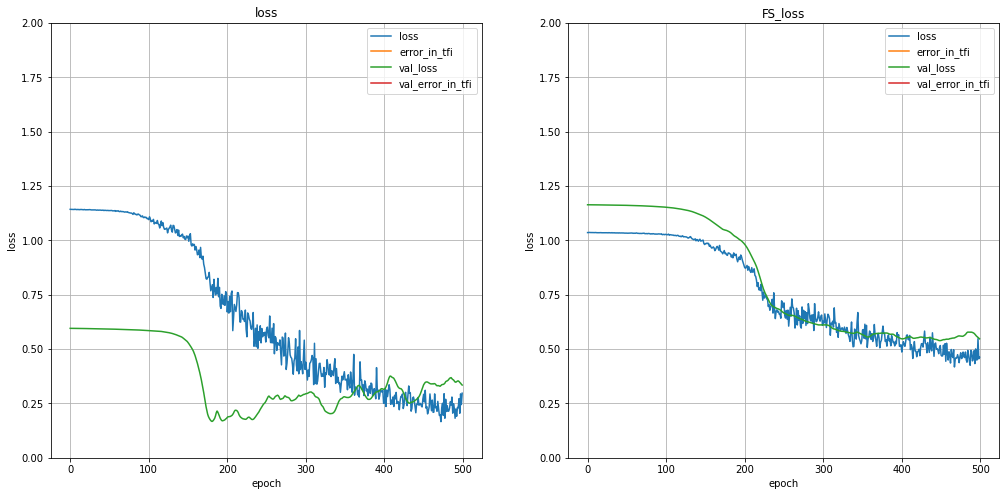

In [76]:
#show learning curves
#mean training loss measured over each epoch
#mean validation loss measured at the end of each epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(17,8))
plot = pd.DataFrame(history.history) #selecting columns
FS_plot = pd.DataFrame(FS_history.history)
plot.plot(ax=axes[0],ylim=(0,2),title="loss",xlabel='epoch',ylabel='loss').grid(True)
FS_plot.plot(ax=axes[1],ylim=(0,2),title="FS_loss",xlabel='epoch',ylabel='loss').grid(True)
#plt.savefig("plots/loss_and_matrics.png")

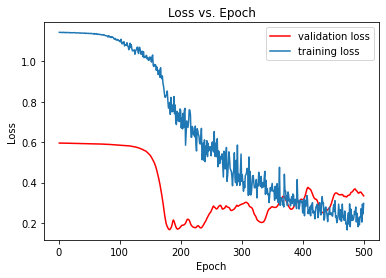

In [77]:
def plot_loss(history):
        train_loss=history.history['loss']
        val_loss=history.history['val_loss']
        x=list(range(1,len(val_loss)+1))
        plt.plot(x,val_loss,color='red',label='validation loss')
        plt.plot(x,train_loss,label='training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()

plot_loss(history)

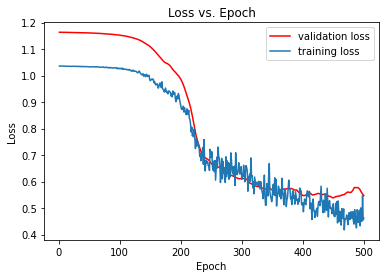

In [78]:
def plot_loss(history):
        train_loss=history.history['loss']
        val_loss=history.history['val_loss']
        x=list(range(1,len(val_loss)+1))
        plt.plot(x,val_loss,color='red',label='validation loss')
        plt.plot(x,train_loss,label='training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()

plot_loss(FS_history)